## 分析PTT八卦版 林襄 相關文章之詞彙關係
- 資料來源 : 八卦版的林襄相關文章
- 日期區間 : 2022-01-01 ~ 2025-03-31

### 載入所需套件

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [153]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [154]:
# 設定文字雲中文字體路徑
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # Windows
# plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']  # Mac/Linux，需安裝字體
plt.rcParams['axes.unicode_minus'] = False  # 顯示負號

### 資料前處理

In [187]:
#匯入資料
df = pd.read_csv('raw_data/sna2025s_11_993b3435c4_5.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1613557348....,[新聞]樂天女孩預告史上最多成員女團現身,2021-02-17 18:22:26,backere0720,Gossiping,三立新聞網\n\n記者王怡翔 2021年2月17日\n\n樂天女孩預告 史上最多成員女團現...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""gogoabc"", ""c...",42.72.62.243,2021-02-18 00:57:04,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1615636402....,[新聞]徐乃麟「輸不起」變品牌註冊「胃得勝」,2021-03-13 19:53:18,BepHbin,Gossiping,https://tinyurl.com/p5a2wkj9\n聯合\n\n徐乃麟「輸不起」變品...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""zxc17893"", ""...",111.71.93.251,2021-03-14 00:40:27,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1616566461....,[問卦]林襄跟山君誰跳舞比較強？,2021-03-24 14:14:19,taker627,Gossiping,大家好 小弟弟我呢\n\n剛剛朋友傳了桃猿今年最強新人林襄跳舞的影片給我看\nhttps:/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Ayanami5566""...",101.12.92.39,2021-03-25 00:25:15,ptt


###  資料清理  

In [293]:
MetaData = df.copy()

# 填充缺失值為空字串
MetaData['artContent'] = MetaData['artContent'].fillna('')
# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1613557348....,[新聞]樂天女孩預告史上最多成員女團現身,2021-02-17 18:22:26,三立新聞網\n\n記者王怡翔 2021年2月17日\n\n樂天女孩預告 史上最多成員女團現...,三立新聞網記者王怡翔年月日樂天女孩預告史上最多成員女團現身中華職棒新球季即將在月展開不只球員...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1615636402....,[新聞]徐乃麟「輸不起」變品牌註冊「胃得勝」,2021-03-13 19:53:18,https://tinyurl.com/p5a2wkj9\n聯合\n\n徐乃麟「輸不起」變品...,聯合徐乃麟輸不起變品牌註冊胃得勝嗅到商機藝人徐乃麟進軍拌麵市場今日在西門町舉辦輸不起拌麵上市...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1616566461....,[問卦]林襄跟山君誰跳舞比較強？,2021-03-24 14:14:19,大家好 小弟弟我呢\n\n剛剛朋友傳了桃猿今年最強新人林襄跳舞的影片給我看\nhttps:/...,大家好小弟弟我呢剛剛朋友傳了桃猿今年最強新人林襄跳舞的影片給我看我看了一下覺得還是我大山君跳...


### 文章斷詞與整理

In [294]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [295]:
# 參數形式手動加入字詞
# 定義要添加的詞彙
words_to_add = ['媒體來源', '記者署名', '完整新聞標題', '完整新聞內文', '完整新聞連結', '備註', '新聞連結網址', '桃猿啦啦隊', '樂天女孩', '啦啦隊女神', '樂天桃猿', '中華職棒', '綜合報導', '愛莉莎莎', '台灣啦啦隊', '樂天啦啦隊' ]

# 使用迴圈添加
for word in words_to_add:
    jieba.add_word(word)

Building prefix dict from c:\Users\user\Desktop\研究所\社群媒體分析_MIS581\讀書會\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uabeb798af088e864c748d6a8464461bd.cache
Loading model cost 0.594 seconds.
Prefix dict has been built successfully.


In [296]:
# 參數形式手動加入停用字
user_stop = ['未滿', '中文字', '水桶', '繁體', '看板', '嚴格', '禁止', '八卦', '表示', '留言', '媒體來源', '記者署名', '完整新聞標題', '完整新聞內文', '完整新聞連結', '備註', '新聞連結網址', '記者', '報導']
for i in user_stop:
    stopWords.append(i)

In [297]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

### 找出重要詞彙 - 以TFIDF為例

TF-IDF用來評估單詞對於文件的集合的重要程度。

資料清洗

In [298]:
# 複製數據集
ball_df = MetaData.copy()

# 保留需要的欄位
ball_df = ball_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
ball_df['word'] = ball_df.sentence.apply(getToken).map(' '.join)
    
# Bag of Word
vectorizer = CountVectorizer(stop_words=stopWords)
X = vectorizer.fit_transform(ball_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())


統計TF-IDF值

In [299]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())


 取每一個字詞在所有文件裡的TF-IDF平均值

In [300]:
ball_tfidf = TFIDF_df.mean().to_frame().reset_index()
ball_tfidf.columns = ["word", "avg"]

ball_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
9035,林襄,0.042991
3212,台灣,0.026138
3724,啦啦隊,0.024206
8866,李多慧,0.017018
8687,有沒有,0.015958
10920,現在,0.015189
13035,肥宅,0.015048
4743,女神,0.013304
11551,看到,0.012974
8100,新聞,0.012831


- 可看出林襄、台灣、啦啦隊、李多慧等詞彙常被提到。

### 透過結巴斷詞與N-gram幫助建立斷詞字典

###  Bigram
統計最常出現前10的bigram組合

In [301]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [302]:
ball_bigram = MetaData.copy()

ball_bigram["word"] = ball_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
ball_bigram = ball_bigram.explode('word')

# 計算每個組合出現的次數
ball_bigram_count = ball_bigram['word'].value_counts().reset_index()

ball_bigram_count.sort_values('count', ascending=False).head(10)


,word,count
0,小妹 台大,71
1,肥宅 小妹,56
2,台灣 美女,48
3,女神 林襄,47
4,啦啦隊女神 林襄,41
5,看到 林襄,41
6,企鵝 姐姐,41
7,林襄 李多慧,38
8,隔壁 房間,38
9,房間 睡覺,35


### Trigram
統計最常出現前10的trigram組合

In [303]:
ball_trigram = MetaData.copy()

ball_trigram["word"] = ball_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
ball_trigram = ball_trigram.explode('word')

# 計算每個組合出現的次數
ball_trigram_count = ball_trigram['word'].value_counts().reset_index()

ball_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,肥宅 小妹 台大,56
1,隔壁 房間 睡覺,35
2,有專 板本 萬能,23
3,板本 萬能 問板,23
4,政治 問卦 嚴重,22
5,問卦 嚴重 板論,22
6,不煙 不酒 夜店,19
7,萬能 問板 三則,16
10,問板 三則 政治,15
9,三則 政治 問卦,15


上面的 bigram 和 trigram 的結果中，是反覆測試後的結果，已在每一次測試過程中，利用參數形式手動加入字詞，幫助斷詞能更準確，直到最終沒有可以合併的字詞。

最終斷詞字典加入以下字詞：
 <br>['媒體來源', '記者署名', '完整新聞標題', '完整新聞內文', '完整新聞連結',' 備註', '新聞連結網址',' 桃猿啦啦隊', '樂天女孩', '啦啦隊女神', '樂天桃猿', '中華職棒', '綜合報導', '愛莉莎莎', '台灣啦啦隊', '樂天啦啦隊' ]

最終停用字典加入以下字詞：
 <br>[['未滿', '中文字', '水桶', '繁體', '看板', '嚴格', '禁止', '八卦', '表示', '留言', '媒體來源', '記者署名', '完整新聞標題', '完整新聞內文', '完整新聞連結', '備註', '新聞連結網址', '記者', '報導']

###  Bigram視覺化

資料準備：取得 bigram 斷詞間的出現頻率

In [304]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))


In [305]:
# 建立bigram和count的dictionary
# 這裡取最多的前25項
d = {k:v for k,v in bigramfdist.most_common(25)}

In [306]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

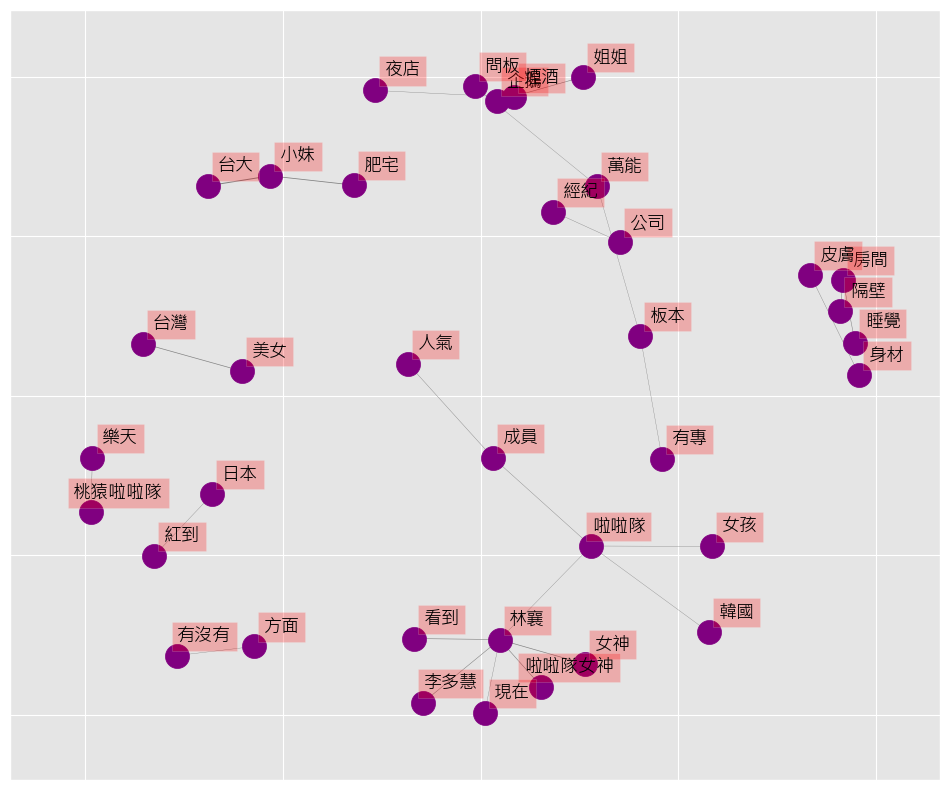

In [307]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

- 可看到("林襄"、"李多慧"、"啦啦隊女神")等字詞常一起出現討論。

利用Pearson correlation計算兩個詞彙間的相關性

In [308]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)

# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

由高到低找出兩個字詞間的相關性

In [309]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
87217,睡覺,隔壁,0.988422
65390,隔壁,睡覺,0.988422
31852,台大,小妹,0.777559
15706,小妹,台大,0.777559
57676,夜店,煙酒,0.753335
22992,煙酒,夜店,0.753335
63676,夜店,皮膚,0.647056
23012,皮膚,夜店,0.647056
32044,肥宅,小妹,0.627336
73306,小妹,肥宅,0.627336


找出 和 「啦啦隊女神」, 「樂天女孩」 相關性最高的 10 個詞彙

In [320]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "啦啦隊女神")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "樂天女孩")].sort_values(by = ['cor'], ascending = False).head(10)

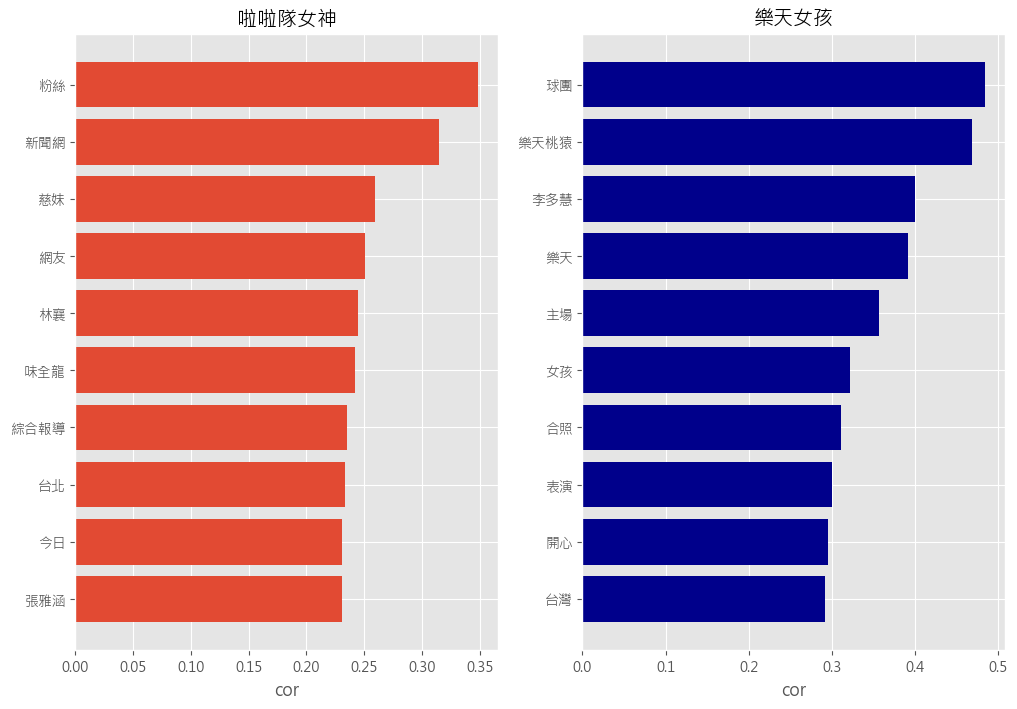

In [321]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('啦啦隊女神')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('樂天女孩')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

- 可看到 啦啦隊女神 和("粉絲"、"慈妹"、"林襄")這些詞的相關性比較高。
- 可看到 樂天女孩 和("球團"、"李多慧")這些詞的相關性比較高。

###  使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [312]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [313]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df.sort_values('cor', ascending=False)

,word1,word2,cor
0,小妹,台大,0.777559
5,台大,小妹,0.777559
20,小妹,肥宅,0.627336
6,肥宅,小妹,0.627336
19,台大,肥宅,0.576018
1,肥宅,台大,0.576018
9,韓國,李多慧,0.466964
21,李多慧,韓國,0.466964
8,樂天女孩,李多慧,0.400447
15,李多慧,樂天女孩,0.400447


In [314]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

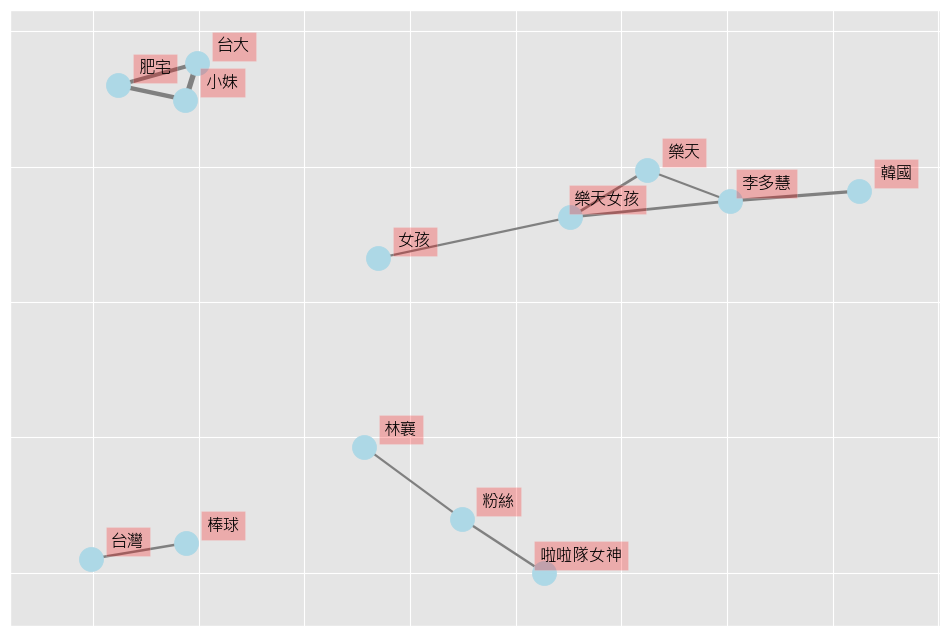

In [317]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

- 可看到("林襄"、"粉絲"、"啦啦隊女神")("樂天女孩"、"李多慧"、"韓國")這些字眼常一起出現。

# 文件分類

「文件分類」主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇使用東森新聞網的三個版別文章進行分類器訓練和評估，最後使用聯合新聞的文章進行預測。

## 分析目標
+ 模型訓練資料內容：
    + 資料來源：東森新聞網(EBC)
    + 版別：體育、國際、財經
    + 區間：2024/09/01-2025/02/28
+ 測試資料內容：
    + 資料來源：聯合新聞網(UDN)
    + 版別：運動、產經、股市、全球
    + 區間：2025/03/15-2025/03/31

* 分析重點：將東森新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行聯合新聞網的版別分類預測。



## 1. 套件說明
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import os
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib.font_manager as fm

In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定文字雲中文字體路徑
FontPath = 'raw_data/SourceHanSansTW-Regular.otf'
fprop = fm.FontProperties(fname=FontPath)

## 2. 文字前處理
`EBC_News.xlsx`裡面包含了要分析的 EBC 新聞資料。
- 版別：sport體育、world國際、business財經
- 時間範圍：2024/02/01 ~ 2024/02/29
- Tarflow工作流程平台搜尋/排除關鍵字：無
- 為避免分類器模型，容易學會只預測「多數類別」就能得到高準確率類別，觀察數據財經數量最少為980篇，故將「國際」及「體育」版別資料，隨機抽樣1,000篇以平衡類別。

In [ ]:
# 取得資料夾中所有EBC各版別之 CSV 檔案名稱
folder_path = 'raw_data/EBC'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 讀取並合併
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
ebc_raw = pd.concat(df_list, ignore_index=True)

# 轉換日期欄位為 datetime 格式
ebc_raw['artDate'] = pd.to_datetime(ebc_raw['artDate'], errors='coerce')

# 顯示合併後的 DataFrame 前幾筆
ebc_raw.head(3)

# 看看有幾篇文章
print(f"number of posts: {ebc_raw.shape[0]}")
print(f"date range: {(ebc_raw['artDate'].min(), ebc_raw['artDate'].max())}")
print(f"category: \n{ebc_raw['artCatagory'].value_counts()}")

number of posts: 6309
date range: (Timestamp('2024-09-01 06:00:00'), Timestamp('2025-02-28 22:57:00'))
category: 
artCatagory
國際    2644
體育    1621
財經     980
Name: count, dtype: int64


In [ ]:
# 設定每類別抽取的最大篇數（例如 1000 篇）
target_samples = 1000
# 分類別抽取樣本，並保證每個類別最多抽取 target_samples 篇
ebc = ebc_raw.groupby('artCatagory').apply(lambda x: x.sample(n=min(target_samples, len(x)), random_state=42)).reset_index(drop=True)
# 顯示抽樣後的結果
print(f"Balanced category distribution: \n{ebc['artCatagory'].value_counts()}")
# 檢視抽樣後的資料
ebc.head(3)

Balanced category distribution: 
artCatagory
國際    1000
體育    1000
財經     980
Name: count, dtype: int64


C:\Users\Etta\AppData\Local\Temp\ipykernel_11772\303785647.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ebc = ebc_raw.groupby('artCatagory').apply(lambda x: x.sample(n=min(target_samples, len(x)), random_state=42)).reset_index(drop=True)


,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,890,史上最強銀彈後援！馬斯克助川普重返白宮之路,https://news.ebc.net.tw/news/world/452395,2024-11-06 16:43:00,國際,美國總統大選開票從台灣時間6日早上開始進行，在15點15分時，川普贏得賓州與威斯康辛兩大搖擺...,EBC
1,1111,日富豪「興奮劑」中毒亡！女優嫩妻驚吐實情：為錢才嫁,https://news.ebc.net.tw/news/world/454522,2024-11-17 17:44:00,國際,日本富豪野崎幸助，於2018年因急性興奮劑中毒不幸身亡，前妻須藤早貴被指控謀殺，目前正在接受...,EBC
2,1310,不滿遊戲政治正確？馬斯克放話欲買下玩具商「孩之寶」,https://news.ebc.net.tw/news/world/457026,2024-11-30 20:25:00,國際,世界上第一款、角色扮演桌遊「龍與地下城」日前陷入政治正確風波，遊戲公司孩之寶更改了遊戲中的種...,EBC


### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
# 過濾 nan 的資料
ebc=ebc.dropna(subset=['artTitle'])
ebc = ebc.dropna(subset=['artContent'])
# 移除網址格式
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,890,史上最強銀彈後援馬斯克助川普重返白宮之路,https://news.ebc.net.tw/news/world/452395,2024-11-06 16:43:00,國際,美國總統大選開票從台灣時間日早上開始進行在點分時川普贏得賓州與威斯康辛兩大搖擺州獲得張選舉人...,EBC
1,1111,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁,https://news.ebc.net.tw/news/world/454522,2024-11-17 17:44:00,國際,日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須藤早貴被指控謀殺目前正在接受和歌山地方法院...,EBC
2,1310,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶,https://news.ebc.net.tw/news/world/457026,2024-11-30 20:25:00,國際,世界上第一款角色扮演桌遊龍與地下城日前陷入政治正確風波遊戲公司孩之寶更改了遊戲中的種族設定引...,EBC


In [ ]:
# 文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。
ebc["content"] = ebc["artTitle"] + ebc["artContent"]
ebc = ebc[["content", "artUrl", "artCatagory","artDate"]]  # 文章內容 文章連結
ebc.head()

,content,artUrl,artCatagory,artDate
0,史上最強銀彈後援馬斯克助川普重返白宮之路美國總統大選開票從台灣時間日早上開始進行在點分時川普...,https://news.ebc.net.tw/news/world/452395,國際,2024-11-06 16:43:00
1,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須...,https://news.ebc.net.tw/news/world/454522,國際,2024-11-17 17:44:00
2,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶世界上第一款角色扮演桌遊龍與地下城日前陷入政治正...,https://news.ebc.net.tw/news/world/457026,國際,2024-11-30 20:25:00
3,質疑店員做披薩沒戴手套歲男竟狠心槍殺對方美國威斯康辛州一名歲男子查爾斯萊格特因為在訂購披薩時...,https://news.ebc.net.tw/news/world/450628,國際,2024-10-28 16:42:00
4,煮飯只顧滑滑滑陸女手機滑進油鍋報銷中國大陸一名女子在油鍋前做菜時只顧著滑手機結果手一滑手機不...,https://news.ebc.net.tw/news/world/453547,國際,2024-11-12 16:51:00


In [ ]:
# 看看有幾篇文章
print(f"total docs: {ebc.shape[0]}")

total docs: 2980


### 2.2 斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
ebc["words"] = ebc["content"].apply(getToken).map(" ".join)
ebc.head()

Building prefix dict from d:\碩士生活\113年下學期\MIS581_社群媒體分析\讀書會\Team11_文件分類\dict\dict.txt.big ...
Loading model from cache C:\Users\Etta\AppData\Local\Temp\jieba.u977980b0d3293025fda7f263d0cb1648.cache
Loading model cost 1.328 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,史上最強銀彈後援馬斯克助川普重返白宮之路美國總統大選開票從台灣時間日早上開始進行在點分時川普...,https://news.ebc.net.tw/news/world/452395,國際,2024-11-06 16:43:00,史上 最強 銀彈 後援 馬斯克 助川普 重返 白宮 美國 總統大選 開票 台灣 時間 早上 ...
1,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須...,https://news.ebc.net.tw/news/world/454522,國際,2024-11-17 17:44:00,富豪 興奮劑 中毒 女優 妻驚 實情 日本 富豪 野崎幸 助於 急性 興奮劑 中毒 不幸身亡...
2,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶世界上第一款角色扮演桌遊龍與地下城日前陷入政治正...,https://news.ebc.net.tw/news/world/457026,國際,2024-11-30 20:25:00,遊戲 政治 正確 馬斯克 放話 買下 玩具商 孩之寶 世界 第一款 角色扮演 桌遊龍 地下城...
3,質疑店員做披薩沒戴手套歲男竟狠心槍殺對方美國威斯康辛州一名歲男子查爾斯萊格特因為在訂購披薩時...,https://news.ebc.net.tw/news/world/450628,國際,2024-10-28 16:42:00,質疑 店員 披薩 沒戴 手套 男竟 狠心 槍殺 對方 美國 威斯康辛 男子 查爾斯 萊格特 ...
4,煮飯只顧滑滑滑陸女手機滑進油鍋報銷中國大陸一名女子在油鍋前做菜時只顧著滑手機結果手一滑手機不...,https://news.ebc.net.tw/news/world/453547,國際,2024-11-12 16:51:00,煮飯 只顧 滑滑 滑陸 手機 滑進 油鍋 報銷 中國 大陸 女子 油鍋 做菜 只顧 著滑 手...


### 2.3 資料集基本檢視

In [ ]:
print(f"total posts: {len(ebc['artUrl'].unique())}")
print(f"category: \n{ebc['artCatagory'].value_counts()}")


total posts: 2980
category: 
artCatagory
國際    1000
體育    1000
財經     980
Name: count, dtype: int64


## 3. 分類模型的訓練流程 (根據7:3的比例切分資料集)
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [ ]:
data = ebc
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

796     雪梨 沙灘 千顆 神秘 黑球 來源 成謎 化驗 出爐 澳洲 雪梨 海邊 日起 陸續 發現 數...
25      情勢 升溫 反抗軍 攻入 監獄 塞德 離境 戰事 監控 團體 敘利亞 人權 瞭望台 組織 反...
2104    魔獸 自爆 經紀人 偷走 事後 氣瘋 巨星 霍華德 短暫 來台 獻技 台灣 職籃史 最大 咖...
696     特斯拉 爆炸 起火 無法 開人 慘死 致命 關鍵 驚悚 近日 加拿大 發生 死亡 車禍 一輛...
1204    新台 積電 員工 分紅 金額 創高 平均 每人 領萬台 積電 召開 董事會 核准 年度 員工...
Name: words, dtype: object
796     國際
25      國際
2104    體育
696     國際
1204    財經
Name: artCatagory, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
國際    33.557047
體育    33.557047
財經    32.885906
Name: proportion, dtype: float64

train percentage :
artCatagory
體育    33.796740
國際    33.557047
財經    32.646213
Name: proportion, dtype: float64

test percentage :
artCatagory
國際    33.557047
財經    33.445190
體育    32.997763
Name: proportion, dtype: float64


## 4. 比較不同模型效果
   + cross-validation 會自動切成 k 組 train-test dataset。  
   + 利用CV挑選最佳模型

In [ ]:
# 定義模型訓練組合，pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):
    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))
    classes = cv_results['estimator'][0].classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          國際       0.95      0.96      0.95       700
          財經       0.96      0.95      0.95       681
          體育       0.99      0.99      0.99       705

    accuracy                           0.97      2086
   macro avg       0.97      0.97      0.97      2086
weighted avg       0.97      0.97      0.97      2086



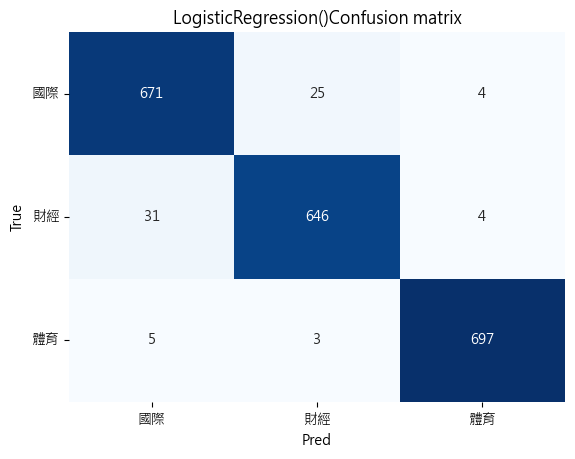

In [ ]:
# 測試Function
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          國際       0.95      0.96      0.95       700
          財經       0.96      0.95      0.95       681
          體育       0.99      0.99      0.99       705

    accuracy                           0.97      2086
   macro avg       0.97      0.97      0.97      2086
weighted avg       0.97      0.97      0.97      2086

now training: clf_dtree
              precision    recall  f1-score   support

          國際       0.85      0.89      0.87       700
          財經       0.90      0.88      0.89       681
          體育       0.96      0.94      0.95       705

    accuracy                           0.90      2086
   macro avg       0.90      0.90      0.90      2086
weighted avg       0.90      0.90      0.90      2086

now training: clf_svm
              precision    recall  f1-score   support

          國際       0.95      0.96      0.95       700
          財經       0.96      0.95      0.95       681
  

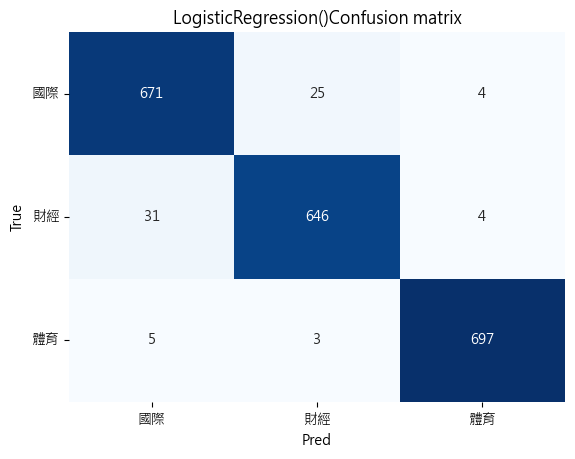

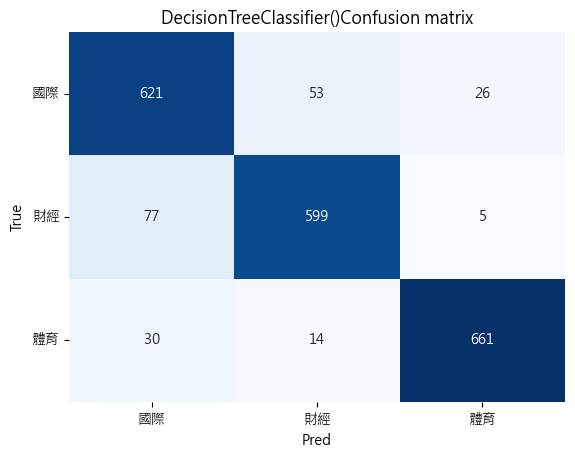

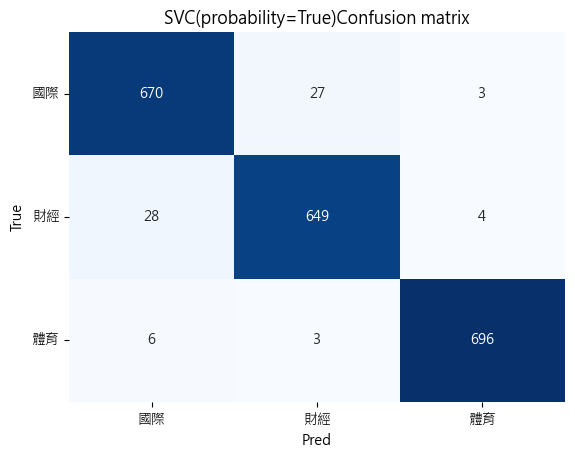

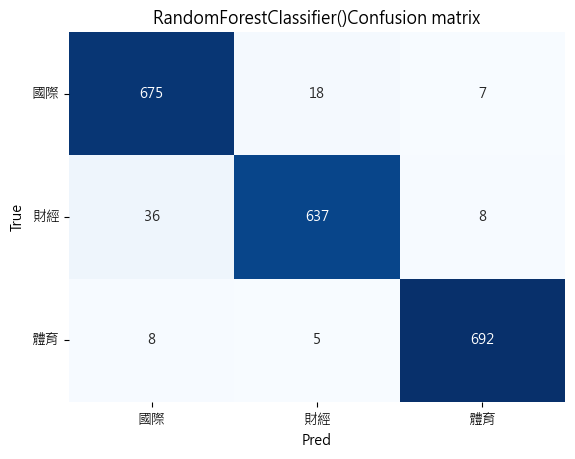

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True)      # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
#vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [ ]:
# 分別觀察各個分類模型在不同類別的評估指標表現如何
result_set['clf_svm']

{'國際': {'precision': 0.9517045454545454,
  'recall': 0.9571428571428572,
  'f1-score': 0.9544159544159544,
  'support': 700.0},
 '財經': {'precision': 0.9558173784977909,
  'recall': 0.9530102790014684,
  'f1-score': 0.9544117647058824,
  'support': 681.0},
 '體育': {'precision': 0.9900426742532006,
  'recall': 0.9872340425531915,
  'f1-score': 0.9886363636363636,
  'support': 705.0},
 'accuracy': 0.9659635666347076,
 'macro avg': {'precision': 0.9658548660685123,
  'recall': 0.9657957262325056,
  'f1-score': 0.9658213609194002,
  'support': 2086.0},
 'weighted avg': {'precision': 0.9660042674610181,
  'recall': 0.9659635666347076,
  'f1-score': 0.9659799694245017,
  'support': 2086.0}}

+ 找出f1-score表現最好的模型作為分類器
  + 測試條件1：使用`CountVectorizer()`特徵提取器，評估模型訓練組合，Best model為clf_rf，Macro avg F1-Score為0.9654。
  + 測試條件2：使用`TfidfVectorizer()`特徵提取器，評估模型訓練組合，Best model為clf_svm，Macro avg F1-Score為0.9658。
+ 兩者差異不大，條件2效能較佳，故選用`TfidfVectorizer()`及`svm.SVC(probability=True)`進行最終模型選擇。

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.9659635666347076,
 'macro avg': {'f1-score': 0.9658213609194002,
               'precision': 0.9658548660685123,
               'recall': 0.9657957262325056,
               'support': 2086.0},
 'weighted avg': {'f1-score': 0.9659799694245017,
                  'precision': 0.9660042674610181,
                  'recall': 0.9659635666347076,
                  'support': 2086.0},
 '國際': {'f1-score': 0.9544159544159544,
        'precision': 0.9517045454545454,
        'recall': 0.9571428571428572,
        'support': 700.0},
 '財經': {'f1-score': 0.9544117647058824,
        'precision': 0.9558173784977909,
        'recall': 0.9530102790014684,
        'support': 681.0},
 '體育': {'f1-score': 0.9886363636363636,
        'precision': 0.9900426742532006,
        'recall': 0.9872340425531915,
        'support': 705.0}}


In [ ]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.94      0.95      0.95       300
          財經       0.95      0.95      0.95       299
          體育       0.99      0.98      0.99       295

    accuracy                           0.96       894
   macro avg       0.96      0.96      0.96       894
weighted avg       0.96      0.96      0.96       894



In [ ]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['國際'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。

## 5. 分析可解釋模型的結果 (以Logistic Regression + CV Tokenizer 為例)

### 5.1 各字詞特徵的迴歸係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ 迴歸係數（coefficient estimates）反映了每個特徵對預測結果的影響程度和方向。​當其他變數保持不變時，某一特徵的值增加一個單位（例如詞頻增加1），其對應的迴歸係數表示該特徵對事件發生機率的影響。
+ 計算後得到勝算比（odds ratio），這表示該特徵每增加一個單位，事件發生的勝算（odds）相對於未增加時的倍數變化。

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

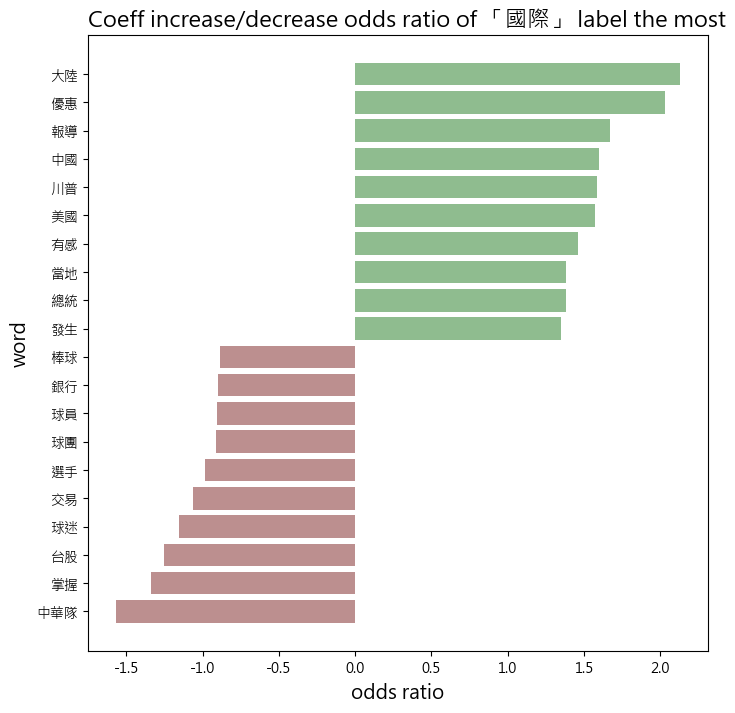

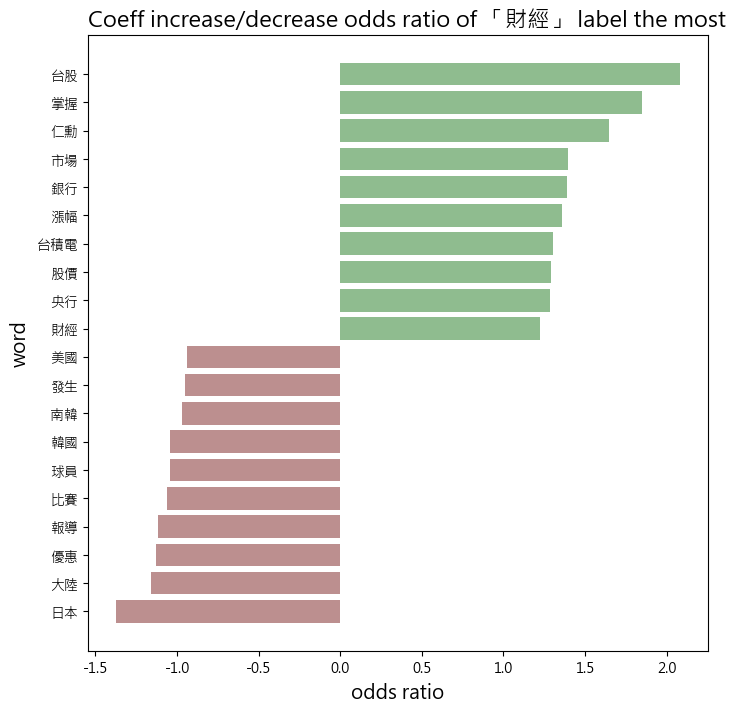

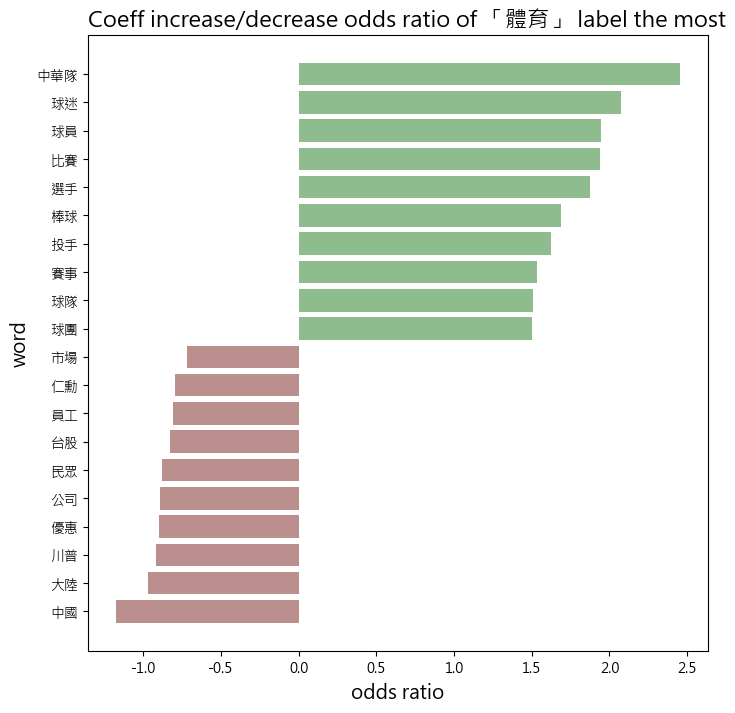

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「國際」中出現了大陸、中國、川普、美國等國際新聞關鍵字；「財經」則是台股、市場、銀行、漲幅、台積電等相關字；「體育」是中華隊、球迷、球員、棒球等相關字。

## 6. 用訓練好的分類器來預測聯合新聞類別

`UDN資料夾` 為聯合新聞網資料夾
- 版別：運動、產經、股市、全球
- 時間範圍：2025/03/15 ~ 2025/03/31
- 工作流程平台搜尋/排除關鍵字：無

In [ ]:
# 設定 CSV 檔案所在的資料夾路徑
udn_path = 'raw_data/UDN'
udn_files = [f for f in os.listdir(udn_path) if f.endswith('.csv')]

# 讀取並合併
df_list = []
for file in udn_files:
    file_path = os.path.join(udn_path, file)
    try:
        df = pd.read_csv(file_path)
        df_list.append(df)
    except Exception as e:
        print(f"讀取檔案 '{file}' 時發生錯誤：{e}")
ct = pd.concat(df_list, ignore_index=True) # 合併所有 DataFrame

# 看看UDN有幾篇文章
print(f"number of posts: {ct.shape[0]}")
print(f"date range: {(ct['artDate'].min(), ct['artDate'].max())}")
print(f"category: \n{ct['artCatagory'].value_counts()}")


number of posts: 7114
date range: ('2025-03-16 01:11:00', '2025-03-31 23:56:00')
category: 
artCatagory
產經    2460
全球    2345
股市    1435
運動     874
Name: count, dtype: int64


In [ ]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 檢查缺失值的欄位，僅留使用欄位
#print(ct.isnull().sum())
ct["content"] = ct["artTitle"] + ct["artContent"]    # 留下 content
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 僅留文章內容 文章連結
ct.dropna(inplace=True) 

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,俄烏戰爭：普京的談判策略與真正意圖（德國之聲中文網）俄羅斯總統普京在談及與烏克蘭停火問題之前...,https://udn.com/news/story/122663/8610554,全球,俄烏 戰爭 普京 談判 策略 真正 意圖 德國 之聲 中文網 俄羅斯 總統 普京 談及 烏克...
1,挺烏盟邦軍事首長3月20日在英國開會 討論維和部隊計畫英國首相施凱爾今天主持1場關於保衛任何...,https://udn.com/news/story/122663/8610615,全球,烏盟 軍事 首長 20 英國 開會 討論 維和部隊 計畫 英國首相 凱爾 主持 保衛 烏克蘭...
2,川普籲俄 勿殺庫斯克被圍烏軍美國總統川普十四日說，他的中東特使威科夫十三日與俄羅斯總統普亭就...,https://udn.com/news/story/122663/8610663,全球,川普籲 庫斯 美國 總統 川普 十四日 中東 特使 科夫 十三日 俄羅斯 總統 普亭 停戰 ...
3,被克宮列拒絕往來戶 凱洛格獲任命烏克蘭特使美國總統川普今天指派凱洛格（Keith Kello...,https://udn.com/news/story/122663/8610833,全球,被克 宮列 拒絕往來 凱洛 格獲 任命 烏克蘭 特使 美國 總統 川普 指派 凱洛 Keit...
4,俄羅斯設停火前提 歐洲為烏克蘭維和俄烏停火談判如火如荼，歐洲也在規劃停戰後怎麼保護烏克蘭！英...,https://udn.com/news/story/122663/8610999,全球,俄羅斯 停火 前提 歐洲 烏克蘭 維和 俄烏 停火 談判 如火如荼 歐洲 規劃 停戰 保護 ...


In [ ]:
# 觀察一下資料集的分佈狀況
ct['artCatagory'].value_counts()

artCatagory
產經    2460
全球    2345
股市    1435
運動     874
Name: count, dtype: int64

+ 將聯合新聞的類別給重新mapping到東森新聞分類器的類別中，接著開始進行分類任務
  + EBC東森新聞類別：體育、財經、國際
  + UDN聯合新聞類別：運動(→體育)、產經(→財經)、股市(→財經)、全球(→國際)

In [ ]:
mapper = {"運動":"體育", "產經":"財經", "股市":"財經", "全球": "國際"} 
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          國際       0.92      0.83      0.87      2345
          財經       0.90      0.96      0.93      3895
          體育       0.98      0.97      0.98       874

    accuracy                           0.92      7114
   macro avg       0.94      0.92      0.93      7114
weighted avg       0.92      0.92      0.92      7114



從classification report可以發現，在東森新聞的資料集EBC上，前面訓練得到的分類器在聯合新聞UDN的表現還不錯，惟「國際」類別表現較差，F1-Score僅0.87。
接著進一步研究分類的結果，嘗試找出問題的原因

In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,俄烏 戰爭 普京 談判 策略 真正 意圖 德國 之聲 中文網 俄羅斯 總統 普京 談及 烏克...,國際,國際
1,烏盟 軍事 首長 20 英國 開會 討論 維和部隊 計畫 英國首相 凱爾 主持 保衛 烏克蘭...,國際,國際
2,川普籲 庫斯 美國 總統 川普 十四日 中東 特使 科夫 十三日 俄羅斯 總統 普亭 停戰 ...,國際,國際
3,被克 宮列 拒絕往來 凱洛 格獲 任命 烏克蘭 特使 美國 總統 川普 指派 凱洛 Keit...,國際,國際
4,俄羅斯 停火 前提 歐洲 烏克蘭 維和 俄烏 停火 談判 如火如荼 歐洲 規劃 停戰 保護 ...,國際,國際
...,...,...,...
7109,長榮 群光 90 天期 美國 關稅 山雨欲來 衝擊 市場 信心 台股 31 重挫 失守 21...,財經,財經
7110,最牛 一輪 欣銓 揚帆 永豐 4B 叫好 欣銓 3264 美國商務部 工業 安全局 BIS ...,財經,財經
7111,全民 權證 美律 五個 美律 2439 透過 收購 MWT Holdings 股權 將可拓 ...,財經,財經
7112,全民 權證 聯詠 挑價 內外 10% 聯詠 3034 受惠 客戶 提前 拉貨 中國 大陸 換...,財經,財經


In [ ]:
# 將錯誤分類的結果篩選出來
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
22,金融時報 投資人 看好 川普 放寬 制裁 尋求 獲利 投資人 看好 美國 總統 川普對 俄羅...,國際,財經
189,地緣 通訊 風險 台灣 聯外 通訊 命懸 海底 電纜 地緣 政治 風險 上升 中國 大陸 漁...,國際,財經
195,有能 避開 川普 關稅 貿易戰 逃生 交易 基金 經理 這裡 總部 設在 倫敦 環球 資產 ...,國際,財經
197,OECD 下修 全球 經濟 展望 普調 關稅 減弱 美墨加 經濟 成長 路透 報導 經濟 合...,國際,財經
199,首付款 蒸發 川普 關稅 拖累 奄奄一息 美國 房市 周刊 Newsweek 17 分析 川...,國際,財經
...,...,...,...
6881,世界 迎去 中化 轉單 地緣 政治 轉單 題材 延燒 世界 先進 5347 24 股價 早盤...,財經,國際
6909,精剛法 受惠 關稅 樂觀 前景 特殊鋼 材料廠 精剛 1584 26 日法 表明 美國 關稅...,財經,國際
6910,精剛 轉單 營運 特殊鋼 材料廠 精剛 1584 26 日法 表明 美國 關稅 中國 大陸 ...,財經,國際
6924,台灣 穩鴻 31 登錄 創櫃板 再添 生力軍 櫃買 中心 Taipei Exchange 創...,財經,國際


In [ ]:
# 觀察看看「國際」類別的新聞，模型給出的分類結果怎麼樣
false_pred.loc[false_pred['artCatagory']=='國際', :].head(20)

,words,artCatagory,pred
22,金融時報 投資人 看好 川普 放寬 制裁 尋求 獲利 投資人 看好 美國 總統 川普對 俄羅...,國際,財經
189,地緣 通訊 風險 台灣 聯外 通訊 命懸 海底 電纜 地緣 政治 風險 上升 中國 大陸 漁...,國際,財經
195,有能 避開 川普 關稅 貿易戰 逃生 交易 基金 經理 這裡 總部 設在 倫敦 環球 資產 ...,國際,財經
197,OECD 下修 全球 經濟 展望 普調 關稅 減弱 美墨加 經濟 成長 路透 報導 經濟 合...,國際,財經
199,首付款 蒸發 川普 關稅 拖累 奄奄一息 美國 房市 周刊 Newsweek 17 分析 川...,國際,財經
204,FT 最新 訪調 經濟 學者 經濟 成長 預估 提高 預測 一份 最新 訪調 顯示 學者 警...,國際,財經
206,川普 關稅 來亂 全球 白銀 市場 壓力 日增 指標 透露 端倪 川普 發動 貿易戰 已令 ...,國際,財經
209,奧迪 漲價 轉嫁 關稅 德國 福斯 汽車集團 VW 旗下 高檔 品牌 奧迪 Audi 評估 ...,國際,財經
210,關稅 戰下 科技 轉運 風險 新加坡 監管 開放 間求 平衡 新加坡 近期 調查 輝達 晶片...,國際,財經
219,關稅 影響 仁勳 美國 本土 製造 保持 靈活性 重要 輝達 執行長 仁勳 談到 關稅 影響...,國際,財經


In [ ]:
# 挑選一篇「國際」類別的新聞文章觀察看看內容，為何模型會將其分類成「財經」的新聞
pprint(false_pred['words'][195])

('有能 避開 川普 關稅 貿易戰 逃生 交易 基金 經理 這裡 總部 設在 倫敦 環球 資產 公司 Ninety One 旗下 新興 市場 股票 團隊 '
 '管理 規模 110 億美元 資產 自川普 上台 以來 努力 尋找 美國 關稅 不相干 市場 貿易戰 曝險 投資 看好 阿拉伯 聯合 大公國 上市 股票 '
 '放款 機構 阿布 達比 商業銀行 ADCB 房地產 開發商 Emaar Properties Ninety One 新興 市場 股票 共同 投資 組合 '
 '經理 Varun Laijawalla 受訪 阿聯 正在 美國 相反 貿易 夥伴 簽署 協定 並向 移民 開放 邊境 那裡 投資 一種 逃生 交易 獨特 '
 '驅動力 必然 受到 美國 政策 影響 彭博 數據 Laijawalla Archie Hart 共同 管理 基金 名為 American Beacon '
 'Ninety One Emerging Markets Equity Fund 過去 一年 回報率 13% 表現 優於 95% 同行 Laijawall '
 '去年 11 月川普 當選 基金 一直 加碼 阿聯 投資 阿聯 房地產 銀行業 基金 稍早 新增 食品 配送 業者 Talabat 持股 公司 去年 12 '
 'IPO 募資 20 億美元 中東地區 大規模 2024 全球 最大 科技 IPO 基金 最大 持股 陸股 印度 股票 合計 整個 投資 組合 40% '
 '小米 2024 報酬 最大 貢獻者 投資 電商 公司 美團 旅遊 平台 Trip com 美團 正為 首次 擴張 海外 進軍 中東 市場 準備 '
 'Laijawalla 補充 三個 加碼 土耳其 國防 承包商 Aselsan 歐洲 提高 國防 支出 嘉惠該 這家 公司 土耳其 以外 地區 營收 成長 '
 '快過 土耳其 營收 Aselsan 已累 62% 俄烏 停戰 割地 川普明 普亭 討論 俄烏 和談 商量 劃分 資產 川普明將 普亭 通話 俄羅斯 鬆口 '
 '和平 協議 條件 可逆 綠卡 工程師 入境 拘留 母稱 脫光 衣服 暴力 審問 烏克蘭 認了 全面 撤出 俄國 斯克州 蘇賈區 普特 俄烏 幾周 停火 '
 '承諾 跳票 競選 宣稱 24 小時 結束 俄烏 戰爭 川普 諷刺 加拿大 對美

+ 從預測結果來看，可以發現聯合新聞UDN的「全球」類別，也常常會報導"國外財經"的資訊，常常出現財經用詞基金、市場、股票等字，使模型預測成「財經」；； 「財經」類別也多出現多國國家名，使模型預測為「國際」。

+ 整體分類器預測聯合新聞網UDN類別，F1-Score結果「國際」-0.87 / 「財經」-0.93 / 「體育」-0.98 表現結果都算相當不錯！

# 第二次讀書會報告-LDA

組別:第11組

Date:2025/04/

# 1.載入環境及安裝套件

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import os
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
import os
import pyLDAvis
import pyLDAvis.gensim_models
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

#圖型相關設定
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

/opt/anaconda3/envs/SMA/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


# 2.資料前處理

## 2.1資料蒐集
本小組自Tarflow下載EBC 新聞資料。

Data includes:
*   區間 from 2024/09/01-2025/02/28
*   包含以下3板：
*   體育
*   國際
*   財經


## 2.2資料匯入

In [ ]:
# 取得資料夾中所有EBC各版別之 CSV 檔案名稱
folder_path = 'raw_data/EBC'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 讀取並合併
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
ebc_raw = pd.concat(df_list, ignore_index=True)

# 轉換日期欄位為 datetime 格式
ebc_raw['artDate'] = pd.to_datetime(ebc_raw['artDate'], errors='coerce')

# 顯示合併後的 DataFrame 前幾筆
ebc_raw.head(3)

# 看看有幾篇文章
print(f"number of posts: {ebc_raw.shape[0]}")
print(f"date range: {(ebc_raw['artDate'].min(), ebc_raw['artDate'].max())}")
print(f"category: \n{ebc_raw['artCatagory'].value_counts()}")

number of posts: 6309
date range: (Timestamp('2024-09-01 06:00:00'), Timestamp('2025-02-28 22:57:00'))
category: 
artCatagory
國際    2644
體育    1621
財經     980
Name: count, dtype: int64


In [ ]:
# 設定每類別抽取的最大篇數（例如 1000 篇）
target_samples = 1000
# 分類別抽取樣本，並保證每個類別最多抽取 target_samples 篇
ebc = ebc_raw.groupby('artCatagory').apply(lambda x: x.sample(n=min(target_samples, len(x)), random_state=42)).reset_index(drop=True)
# 顯示抽樣後的結果
print(f"Balanced category distribution: \n{ebc['artCatagory'].value_counts()}")
# 檢視抽樣後的資料
ebc.head(3)

Balanced category distribution: 
artCatagory
國際    1000
體育    1000
財經     980
Name: count, dtype: int64


/var/folders/m2/93_7d4l54wj673d4ll4hg6r80000gn/T/ipykernel_7956/303785647.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ebc = ebc_raw.groupby('artCatagory').apply(lambda x: x.sample(n=min(target_samples, len(x)), random_state=42)).reset_index(drop=True)


,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,890,史上最強銀彈後援！馬斯克助川普重返白宮之路,https://news.ebc.net.tw/news/world/452395,2024-11-06 16:43:00,國際,美國總統大選開票從台灣時間6日早上開始進行，在15點15分時，川普贏得賓州與威斯康辛兩大搖擺...,EBC
1,1111,日富豪「興奮劑」中毒亡！女優嫩妻驚吐實情：為錢才嫁,https://news.ebc.net.tw/news/world/454522,2024-11-17 17:44:00,國際,日本富豪野崎幸助，於2018年因急性興奮劑中毒不幸身亡，前妻須藤早貴被指控謀殺，目前正在接受...,EBC
2,1310,不滿遊戲政治正確？馬斯克放話欲買下玩具商「孩之寶」,https://news.ebc.net.tw/news/world/457026,2024-11-30 20:25:00,國際,世界上第一款、角色扮演桌遊「龍與地下城」日前陷入政治正確風波，遊戲公司孩之寶更改了遊戲中的種...,EBC


### 2.1 清理

In [ ]:
# 過濾 nan 的資料
ebc=ebc.dropna(subset=['artTitle'])
ebc = ebc.dropna(subset=['artContent'])
# 移除網址格式
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

ebc.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,890,史上最強銀彈後援馬斯克助川普重返白宮之路,https://news.ebc.net.tw/news/world/452395,2024-11-06 16:43:00,國際,美國總統大選開票從台灣時間日早上開始進行在點分時川普贏得賓州與威斯康辛兩大搖擺州獲得張選舉人...,EBC
1,1111,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁,https://news.ebc.net.tw/news/world/454522,2024-11-17 17:44:00,國際,日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須藤早貴被指控謀殺目前正在接受和歌山地方法院...,EBC
2,1310,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶,https://news.ebc.net.tw/news/world/457026,2024-11-30 20:25:00,國際,世界上第一款角色扮演桌遊龍與地下城日前陷入政治正確風波遊戲公司孩之寶更改了遊戲中的種族設定引...,EBC


In [ ]:
# 文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。
ebc["content"] = ebc["artTitle"] + ebc["artContent"]
# ebc = ebc[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

ebc = ebc.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 留下文章內容 文章連結與文章種類

ebc.head()

,content,artUrl,artCatagory,artDate
0,史上最強銀彈後援馬斯克助川普重返白宮之路美國總統大選開票從台灣時間日早上開始進行在點分時川普...,https://news.ebc.net.tw/news/world/452395,國際,2024-11-06 16:43:00
1,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須...,https://news.ebc.net.tw/news/world/454522,國際,2024-11-17 17:44:00
2,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶世界上第一款角色扮演桌遊龍與地下城日前陷入政治正...,https://news.ebc.net.tw/news/world/457026,國際,2024-11-30 20:25:00
3,質疑店員做披薩沒戴手套歲男竟狠心槍殺對方美國威斯康辛州一名歲男子查爾斯萊格特因為在訂購披薩時...,https://news.ebc.net.tw/news/world/450628,國際,2024-10-28 16:42:00
4,煮飯只顧滑滑滑陸女手機滑進油鍋報銷中國大陸一名女子在油鍋前做菜時只顧著滑手機結果手一滑手機不...,https://news.ebc.net.tw/news/world/453547,國際,2024-11-12 16:51:00


In [ ]:
# 看看有幾篇文章
print(f"total docs: {ebc.shape[0]}")


total docs: 2980


In [ ]:
ebc["artCatagory"]

0       國際
1       國際
2       國際
3       國際
4       國際
        ..
2975    體育
2976    體育
2977    體育
2978    體育
2979    體育
Name: artCatagory, Length: 2980, dtype: object

### 2.2 資料停用詞與斷詞使用

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
ebc["words"] = ebc["content"].apply(getToken)
ebc.head()

Building prefix dict from /Users/ee/Downloads/sma/SMA_2025S/Team11_文件分類/dict/dict.txt.big ...
2025-04-20 14:01:02,591 : DEBUG : Building prefix dict from /Users/ee/Downloads/sma/SMA_2025S/Team11_文件分類/dict/dict.txt.big ...
Loading model from cache /var/folders/m2/93_7d4l54wj673d4ll4hg6r80000gn/T/jieba.u1e86ecb6b4ac3d512a374ce674f37ccf.cache
2025-04-20 14:01:02,594 : DEBUG : Loading model from cache /var/folders/m2/93_7d4l54wj673d4ll4hg6r80000gn/T/jieba.u1e86ecb6b4ac3d512a374ce674f37ccf.cache
Loading model cost 0.661 seconds.
2025-04-20 14:01:03,255 : DEBUG : Loading model cost 0.661 seconds.
Prefix dict has been built successfully.
2025-04-20 14:01:03,256 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,史上最強銀彈後援馬斯克助川普重返白宮之路美國總統大選開票從台灣時間日早上開始進行在點分時川普...,https://news.ebc.net.tw/news/world/452395,國際,2024-11-06 16:43:00,"[史上, 最強, 銀彈, 後援, 馬斯克, 助川普, 重返, 白宮, 美國, 總統大選, 開..."
1,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須...,https://news.ebc.net.tw/news/world/454522,國際,2024-11-17 17:44:00,"[富豪, 興奮劑, 中毒, 女優, 妻驚, 實情, 日本, 富豪, 野崎幸, 助於, 急性,..."
2,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶世界上第一款角色扮演桌遊龍與地下城日前陷入政治正...,https://news.ebc.net.tw/news/world/457026,國際,2024-11-30 20:25:00,"[遊戲, 政治, 正確, 馬斯克, 放話, 買下, 玩具商, 孩之寶, 世界, 第一款, 角..."
3,質疑店員做披薩沒戴手套歲男竟狠心槍殺對方美國威斯康辛州一名歲男子查爾斯萊格特因為在訂購披薩時...,https://news.ebc.net.tw/news/world/450628,國際,2024-10-28 16:42:00,"[質疑, 店員, 披薩, 沒戴, 手套, 男竟, 狠心, 槍殺, 對方, 美國, 威斯康辛,..."
4,煮飯只顧滑滑滑陸女手機滑進油鍋報銷中國大陸一名女子在油鍋前做菜時只顧著滑手機結果手一滑手機不...,https://news.ebc.net.tw/news/world/453547,國際,2024-11-12 16:51:00,"[煮飯, 只顧, 滑滑, 滑陸, 手機, 滑進, 油鍋, 報銷, 中國, 大陸, 女子, 油..."


In [ ]:
#列出此資料集包含哪幾個個版
ebc['artCatagory'].unique()

array(['國際', '財經', '體育'], dtype=object)

顯示不同主題出現最常出現的詞

In [ ]:
## 定義主題 (國際)
international_cnt = ebc.loc[ebc['artCatagory'] == '國際',:]['words'].explode().value_counts().head(100)
international_cnt.index

Index(['美國', '報導', '中國', '總統', '川普', '發生', '台灣', '優惠', '警方', '發現', '日本', '公司',
       '男子', '事件', '民眾', '當地', '南韓', '韓國', '代表', '立場', '大陸', '調查', '授權', '言論',
       '國家', '加入', '網友', '女子', '死亡', '尹錫悅', '消息', '導致', '造成', '時間', '宣布', '當時',
       '出現', '烏克蘭', '生活', '關注', '賀錦麗', '媒體', '品牌', '醫院', '引發', '俄羅斯', '曝光',
       '戒嚴', '消費者', '嚴重', '無法', '有感', '評選', '北韓', '同慶', '優良', '掌握', '攻擊', '問題',
       '小時', '相關', '現場', '以色列', '延伸', '安全', '影響', '行為', '閱讀', '全球', '緊急', '對此',
       '看到', '畫面', '這是', '遭到', '政府', '近日', '工作', '關心', '正在', '孩子', '拜登', '員工',
       '包括', '要求', '情況', '成為', '透露', '女兒', '航空', '強調', '原因', '事故', '支持', '有人',
       '突然', '飛機', '使用', '許多', '人員'],
      dtype='object', name='words')

In [ ]:
## 列出主題字詞(財經)
finance_cnt = ebc.loc[ebc['artCatagory'] == '財經',:]['words'].explode().value_counts().head(200)
pprint(" ".join(finance_cnt.index))

('台股 漲幅 股價 代表 掌握 早盤 台灣 授權 最高 立場 言論 市場 投資 族群 財經 台積 公司 美國 網友 出現 封面 台積電 仁勳 指數 加入 '
 '漲元 萬元 輝達 收元 中國 跌幅 部分 元漲 影響 晶片 電子 億元 資金 積電 員工 漲停 生活 投資人 成交量 全球 未來 股票 一度 權值 表現 '
 '科技 民眾 最低 超過 震盪 分別 銀行 消息 台塑 上漲 經濟 一手 概念股 預期 作收 圖東森 價格 產業 董事長 執行長 相關 報導 股市 關注 '
 '終場 下探 外資 半導體 預估 上市 交易 下跌 時間 需求 成長 營收 川普 集團 央行 預計 宣布 昨日 新光 流入 強勢 風險 近期 增加 問題 '
 '美元 獲利 買單 房價 專家 明年 鴻海 主要 比較 日本 取自 收漲 歷史 以點 去年 平盤 發展 政策 業者 提供 應該 機會 企業 數則 日線 '
 '億美元 黃金 技術 包括 最大 房市 降息 機器人 情況 導致 過去 以元作 利率 示意圖 新高 強調 看到 國際 產品 平均 是否 公布 貸款 配息 '
 '億櫃 金管會 製程 調整 公告 許多 客戶 推出 英特爾 政府 減少 中信 隨後 圖翻 建議 狄驤 維持 選擇 金融 需要 股東 透過 無法 透露 直接 '
 '申購 業務 股民 這是 分析師 先進 挑戰 這次 服務 原因 台北 台幣 穩定 美股 逾點 個股 反彈 分享 特別 成為 關稅 漲點 傳出 覺得 整體 '
 '要求 工作')


In [ ]:
## 列出主題字詞(體育)
sport_cnt = ebc.loc[ebc['artCatagory'] == '體育',:]['words'].explode().value_counts().head(100)
pprint(" ".join(sport_cnt.index))

('中華隊 台灣 投手 棒球 世界 日本 球迷 比賽 經典 球員 賽事 巨蛋 資格賽 選手 先發 聯盟 教練 冠軍 表現 球隊 應援 強賽 延伸 美國 閱讀 '
 '加油 傑憲 中職 職棒 東京 西班牙 拿下 加入 晉級 總教練 全壘打 名單 強看 大谷 這次 鎖定 韓國 敲出 代表 國際 最終 精彩 掌握 成功 '
 '台北 兄弟 日本隊 機會 打擊 擊敗 台灣隊 主播 棒球賽 曾豪駒 林昱珉 道奇 報導 三振 生活 中信 林家 轉播 隊長 尼加拉瓜 中華 一手 '
 '多明尼加 熱血 賽後 奪冠 門票 成為 英雄 超級 關鍵 擔任 去年 成績 相當 特別 委內瑞拉 面對 覺得 以比 言論 味全 立場 授權 球評 二壘 '
 '啦啦隊 投球 體育 領先 現場')


In [ ]:
#自訂主題詞彙(參照上面3個主題的字詞)
custom_topic_word = {
    "國際": [
        "美國", "香港", "國際", "俄羅斯", "全球", "世界", "戰略", "日本", "中國", "大陸", 
        "習近平", "北京", "歐盟", "聯合國", "烏克蘭", "戰爭", "川普", "普丁", "總統", "外交", 
        "政府", "軍事", "外交部", "政治", "軍隊", "峰會", "領導人", "制裁", "談判", "關係", 
        "宣布", "發表", "和平", "衝突", "危機", "聲明", "協議", "會談", "選舉", "總理", 
        "航班", "航空", "事件", "巴統", "事故", "事發", "傷者", "空難", "醫院", "遭遇"
    ],
    "財經": [
        "市場", "成長", "投資", "指數", "台股", "每股", "營運", "股利", "獲利", "現金", 
        "年增", "股價", "投資人", "法人", "銀行", "上漲", "升息", "外資", "殖利率", "股息", 
        "配發", "股票", "基金", "上市", "配息", "金融", "聯準會", "買超", "債券", "動能", 
        "下跌", "漲幅", "經濟", "企業", "產業", "產品", "董事會", "公司", "營收", "庫存", 
        "台積電", "仁勳", "輝達", "鴻海", "半導體", "科技", "電子", "黃仁勳", "尾牙", "航空"
    ],
    "體育": [
        "棒球", "職棒", "比賽", "賽事", "球員", "預賽", "投手", "戰績", "球隊", "賽程", 
        "球迷", "選手", "大聯盟", "春訓", "先發", "比分", "安打", "強賽", "中華隊", "套票", 
        "東森", "巨蛋", "冠軍", "世界棒球", "應援", "門票", "加油", "韓國", "日本", "美國", 
        "郭俊麟", "周思齊", "總教練", "打擊", "聯盟", "籃球", "NBA", "體育", "運動", "得分", 
        "吉力吉撈", "部長", "轉播", "幸運", "骰子", "精彩", "助攻", "球星", "球團", "台美"
    ]
}

從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

In [ ]:
#建立vocabulary
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['NBA', '上市', '上漲', '下跌', '世界', '世界棒球', '中國', '中華隊', '事件', '事故',
       '事發', '仁勳', '企業', '俄羅斯', '債券', '傷者', '先發', '全球', '公司', '冠軍', '制裁',
       '加油', '助攻', '動能', '北京', '升息', '半導體', '協議', '危機', '台積電', '台美', '台股',
       '吉力吉撈', '周思齊', '和平', '國際', '基金', '外交', '外交部', '外資', '大聯盟', '大陸',
       '套票', '安打', '宣布', '尾牙', '峰會', '川普', '巨蛋', '巴統', '市場', '年增', '幸運',
       '庫存', '強賽', '得分', '應援', '成長', '戰爭', '戰略', '戰績', '打擊', '投手', '投資',
       '投資人', '指數', '政府', '政治', '日本', '春訓', '普丁', '會談', '東森', '棒球', '歐盟',
       '殖利率', '每股', '比分', '比賽', '法人', '漲幅', '烏克蘭', '營收', '營運', '獲利', '現金',
       '球員', '球團', '球星', '球迷', '球隊', '產品', '產業', '發表', '科技', '空難', '籃球',
       '精彩', '經濟', '總教練', '總理', '總統', '美國', '習近平', '聯合國', '聯準會', '聯盟',
       '聲明', '職棒', '股價', '股利', '股息', '股票', '航班', '航空', '董事會', '衝突', '談判',
       '買超', '賽事', '賽程', '軍事', '軍隊', '輝達', '轉播', '運動', '遭遇', '選手', '選舉',
       '部長', '郭俊麟', '配息', '配發', '醫院', '金融', '銀行', '門票', '關係', '電子', '韓國',
       '預賽', '領導人', '香港', '骰子', '體育', '鴻海', '黃仁勳

In [ ]:
#利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM
ebc_corpus = ebc['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
ebc_matrix = vectorizer.fit_transform(ebc_corpus)

ebc_matrix = ebc_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

ebc_matrix.shape

DTM_df = pd.DataFrame(columns = feature_names, data = ebc_matrix)
DTM_df

/opt/anaconda3/envs/SMA/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,NBA,上市,上漲,下跌,世界,世界棒球,中國,中華隊,事件,事故,...,關係,電子,韓國,預賽,領導人,香港,骰子,體育,鴻海,黃仁勳
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,0,0,0,0,3,0,1,4,0,0,...,1,0,0,0,0,0,0,0,0,0
2976,0,0,0,0,2,0,0,10,0,0,...,0,0,2,2,0,0,0,0,0,0
2977,0,0,0,0,1,0,1,0,0,0,...,0,0,2,1,0,0,0,0,0,0
2978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


針對每個「自定義主題」，統計每篇文章在該主題下出現的詞彙總次數，整理成一個DataFrame

In [ ]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = ebc_matrix[:, idx].sum(axis=1)
    
df_count

,topic_國際,topic_財經,topic_體育
0,17,0,5
1,1,0,2
2,8,9,2
3,5,0,3
4,4,0,0
...,...,...,...
2975,5,0,26
2976,5,0,37
2977,6,0,22
2978,5,0,23


把每篇文章在各個主題的出現次數轉換成主題分佈機率（比例），也就是 每篇文章屬於各個主題的相對權重（theta 向量）

In [ ]:
#列出θ值
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_國際,topic_財經,topic_體育
0,0.772727,0.000000,0.227273
1,0.333333,0.000000,0.666667
2,0.421053,0.473684,0.105263
3,0.625000,0.000000,0.375000
4,1.000000,0.000000,0.000000


## 2.3處理資料集新聞

In [ ]:
#將斷詞後的dataframe轉成list
docs = ebc['words'].to_list()
docs[0]

['史上',
 '最強',
 '銀彈',
 '後援',
 '馬斯克',
 '助川普',
 '重返',
 '白宮',
 '美國',
 '總統大選',
 '開票',
 '台灣',
 '時間',
 '早上',
 '在點',
 '分時',
 '川普',
 '贏得',
 '賓州',
 '威斯康辛',
 '兩大',
 '搖擺',
 '獲得',
 '選舉人',
 '突破',
 '當選',
 '門檻',
 '成為',
 '美國',
 '第任',
 '總統',
 '選前',
 '美金',
 '億萬富翁',
 '馬斯克',
 '現身',
 '川普',
 '宣布',
 '勝選',
 '現場',
 '川普',
 '台灣',
 '時間',
 '日點',
 '左右',
 '現身',
 '發表',
 '勝選',
 '感言',
 '當他',
 '現身',
 '全場',
 '川粉',
 '興奮',
 '大喊',
 '川普',
 '這是',
 '最棒',
 '政治',
 '運動',
 '國家',
 '發生',
 '過最棒',
 '事情',
 '幫助',
 '國家',
 '痊癒',
 '邊境',
 '問題',
 '處理',
 '好美度',
 '有感',
 '優惠',
 '川普',
 '提到',
 '特別感謝',
 '總統',
 '搭檔',
 '范斯',
 '要當',
 '第一個',
 '祝賀',
 '當選',
 '稱讚',
 '范斯是',
 '充滿',
 '鬥志',
 '總是',
 '深入',
 '網路',
 '控制',
 '敵營',
 '范斯',
 '敵營',
 '出色',
 '表現',
 '感到',
 '滿意',
 '普勝選',
 '提到',
 '特斯拉',
 '執行長',
 '平台',
 '老闆',
 '馬斯克',
 '選前',
 '十分',
 '力挺川普',
 '捐贈',
 '億美元',
 '給川',
 '普外',
 '還在',
 '社群',
 '平台',
 '發表',
 '美國',
 '大選',
 '相關',
 '貼文',
 '累計',
 '瀏覽量',
 '高達',
 '億次',
 '更狂',
 '馬斯克',
 '舉辦',
 '百萬美元',
 '抽獎',
 '活動',
 '這場',
 '每日',
 '百萬美元',
 '抽獎',
 '活動',
 '質疑',
 '經營',
 '非法',
 '樂透並

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
#篩選條件為字詞出現在少於五篇文章中或在99的文章中都會出現的字詞皆剔除
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-20 14:01:11,908 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-20 14:01:12,119 : INFO : built Dictionary<59931 unique tokens: ['一度', '一直', '中有', '事先', '事實上']...> from 2980 documents (total 534098 corpus positions)
2025-04-20 14:01:12,119 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<59931 unique tokens: ['一度', '一直', '中有', '事先', '事實上']...> from 2980 documents (total 534098 corpus positions)", 'datetime': '2025-04-20T14:01:12.119802', 'gensim': '4.3.3', 'python': '3.11.0 (main, Mar  1 2023, 12:33:14) [Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'created'}
2025-04-20 14:01:12,138 : INFO : discarding 48758 tokens: [('人間', 4), ('代言人', 3), ('億次', 2), ('分時', 4), ('力挺川普', 1), ('助川普', 1), ('好美度', 1), ('密不可分', 4), ('川粉', 4), ('感言', 3)]...
2025-04-20 14:01:12,139 : INFO : keeping 11173 tokens which were in no less than 5 and no more than 2950 (=99.0%) documents
2025-04-20 14:01:12,150 : INFO : resulting dictionary: Dictiona

Dictionary<11173 unique tokens: ['一度', '一直', '中有', '事先', '事實上']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一度: 0
一直: 1
中有: 2
事先: 3
事實上: 4
事情: 5
代言: 6
保護: 7
價值: 8
億美元: 9
億萬富翁: 10
優惠: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(ebc['words'].iloc[600]))


('老婦 醫院 宣告 死亡 葬禮 屍體 一半 手指 竟動 西班牙 最近 傳出 離譜 烏龍 事件 老婦人 醫院 宣告 死亡 遺體 送往 殯儀館 葬禮 相關 '
 '人員 裹屍 袋時 發現 老婦 手指 突然 嚇壞 現場 眾人 老婦 醫院 急救 安寧 病房 院方 正在 釐清 醫師 何會 發生 嚴重錯誤 外媒 鏡報 報導 '
 '西班牙 未公開 姓名 年齡 老婦人 中午 馬約 卡島 帕爾馬 醫院 宣告 死亡 遺體 安排 救護車 送往 附近 殯儀館 怎料 殯儀館 工作人員 發現 '
 '不對勁 西班牙 當地 報導 工作人員 遺體 屍袋 包到 一半 死者 手指 竟動 老婦 突然 復活 嚇一跳 益比喜 年終 感恩 全館 工作人員 很快 '
 '冷靜下來 醫護人員 確定 老婦 生命 跡象 一行 醫院 急救 老婦 身體狀況 虛弱 住進 安寧 病房 老婦 暫時 下來 身體狀況 能否 恢復健康 仍待 '
 '治療 觀察 這起 烏龍 事件 曝光 醫院 展開 內部 調查 釐清 宣告 老婦 死亡 醫師 活人 宣告 死亡 查明 過程 中有何 疏漏 西班牙 馬約 卡島 '
 '帕爾馬 市政廳 當地 衛生部門 負責人 尚未 此事 作回 報導 周杰倫 張惠妹 三天三夜 劇烈 晃動 民眾 不敢 跳快 內湖 母女 受騙 報案 嘲諷 '
 '走上 絕路 承辦 員警 去年 檢舉 態度惡劣 原始 連結 言論 授權 代表 立場')


第600篇文章的前十個詞彙的語料庫ID和頻率

In [ ]:
dictionary.doc2bow(ebc['words'].iloc[600])[:10]

[(78, 1),
 (84, 1),
 (87, 1),
 (169, 3),
 (207, 1),
 (316, 2),
 (328, 1),
 (348, 1),
 (350, 2),
 (352, 1)]

#### 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]
#確認corpus型態
type(corpus)

list

# 3.訓練 topic model(LDA)

## 3.1參數說明：

corpus = 文檔語料庫

id2word = 詞彙字典

num_topics = 生成幾個主題數

random_state = 固定亂數值，每次的模型結果會一樣

iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂

passes(epoch) = 整個 corpus 訓練模型的次數

alpha = 文章主題分佈

eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該使用相同的資料，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
    #建立模型
    ldamodel = LdaModel(
        corpus=corpus, 
        id2word=dictionary, # 字典
        num_topics=9, # 生成幾個主題數
        random_state=2024, # 亂數
    )

2025-04-20 14:01:12,542 : INFO : using symmetric alpha at 0.1111111111111111
2025-04-20 14:01:12,543 : INFO : using symmetric eta at 0.1111111111111111
2025-04-20 14:01:12,545 : INFO : using serial LDA version on this node
2025-04-20 14:01:12,552 : INFO : running online (single-pass) LDA training, 9 topics, 1 passes over the supplied corpus of 2980 documents, updating model once every 2000 documents, evaluating perplexity every 2980 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 14:01:12,552 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-20 14:01:12,552 : INFO : PROGRESS: pass 0, at document #2000/2980
2025-04-20 14:01:13,110 : INFO : merging changes from 2000 documents into a model of 2980 documents
2025-04-20 14:01:13,114 : INFO : topic #4 (0.111): 0.007*"美國" + 0.006*"台灣" + 0.005*"報導" + 0.004*"員工" + 0.004*"網友" + 0.003*"中國" + 0.003*"仁勳" + 0.003*"輝達" + 0.003*"掌握" 

# 3.2 查看 LDA 主題代表字

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。
num_words = 選擇要查看每個主題前幾個字。

In [ ]:
ldamodel.print_topics()

2025-04-20 14:01:13,785 : INFO : topic #0 (0.111): 0.026*"中華隊" + 0.011*"台灣" + 0.011*"球迷" + 0.011*"經典" + 0.010*"球員" + 0.010*"棒球" + 0.008*"比賽" + 0.007*"世界" + 0.007*"巨蛋" + 0.007*"資格賽"
2025-04-20 14:01:13,787 : INFO : topic #1 (0.111): 0.014*"投手" + 0.009*"尼加拉瓜" + 0.007*"先發" + 0.007*"西班牙" + 0.006*"台灣" + 0.006*"資格賽" + 0.006*"球隊" + 0.006*"首戰" + 0.005*"日本" + 0.005*"徐若熙"
2025-04-20 14:01:13,787 : INFO : topic #2 (0.111): 0.006*"美國" + 0.006*"台灣" + 0.005*"最高" + 0.004*"漲幅" + 0.004*"立場" + 0.004*"早盤" + 0.004*"掌握" + 0.004*"代表" + 0.004*"公司" + 0.004*"中國"
2025-04-20 14:01:13,789 : INFO : topic #3 (0.111): 0.022*"台灣" + 0.018*"中華隊" + 0.017*"日本" + 0.011*"投手" + 0.010*"世界" + 0.007*"棒球" + 0.006*"賽事" + 0.005*"冠軍" + 0.005*"強賽" + 0.005*"比賽"
2025-04-20 14:01:13,790 : INFO : topic #4 (0.111): 0.013*"林昱珉" + 0.011*"台灣" + 0.006*"巨蛋" + 0.005*"日本" + 0.005*"美國" + 0.005*"加油" + 0.004*"林立" + 0.004*"報導" + 0.004*"世界" + 0.004*"台北"
2025-04-20 14:01:13,791 : INFO : topic #5 (0.111): 0.006*"台灣" + 0.006*"美國" + 0.005*"代表隊" + 0.005

[(0,
  '0.026*"中華隊" + 0.011*"台灣" + 0.011*"球迷" + 0.011*"經典" + 0.010*"球員" + 0.010*"棒球" + 0.008*"比賽" + 0.007*"世界" + 0.007*"巨蛋" + 0.007*"資格賽"'),
 (1,
  '0.014*"投手" + 0.009*"尼加拉瓜" + 0.007*"先發" + 0.007*"西班牙" + 0.006*"台灣" + 0.006*"資格賽" + 0.006*"球隊" + 0.006*"首戰" + 0.005*"日本" + 0.005*"徐若熙"'),
 (2,
  '0.006*"美國" + 0.006*"台灣" + 0.005*"最高" + 0.004*"漲幅" + 0.004*"立場" + 0.004*"早盤" + 0.004*"掌握" + 0.004*"代表" + 0.004*"公司" + 0.004*"中國"'),
 (3,
  '0.022*"台灣" + 0.018*"中華隊" + 0.017*"日本" + 0.011*"投手" + 0.010*"世界" + 0.007*"棒球" + 0.006*"賽事" + 0.005*"冠軍" + 0.005*"強賽" + 0.005*"比賽"'),
 (4,
  '0.013*"林昱珉" + 0.011*"台灣" + 0.006*"巨蛋" + 0.005*"日本" + 0.005*"美國" + 0.005*"加油" + 0.004*"林立" + 0.004*"報導" + 0.004*"世界" + 0.004*"台北"'),
 (5,
  '0.006*"台灣" + 0.006*"美國" + 0.005*"代表隊" + 0.005*"世界" + 0.004*"教練" + 0.004*"中國" + 0.004*"選手" + 0.004*"本屆" + 0.004*"仁勳" + 0.003*"川普"'),
 (6,
  '0.006*"古巴" + 0.005*"中信" + 0.005*"美國" + 0.004*"言論" + 0.004*"日本" + 0.004*"台灣" + 0.004*"授權" + 0.004*"先發" + 0.004*"立場" + 0.003*"球隊"'),
 (7,
  '0.008*"南非

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(2, 0.8251034), (4, 0.10751642), (5, 0.063707225)]

## 3.3 查看 LDA 模型指標 

perplexity: 評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

Pointwise Mutual Information (PMI) :
自然語言處理中，想要探討兩個字之間是否存在某種關係。

例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。

In [ ]:
# perplexity(越小越好)
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-20 14:01:14,974 : INFO : -8.630 per-word bound, 396.2 perplexity estimate based on a held-out corpus of 2980 documents with 441920 words


-8.630069271080158

In [ ]:
np.exp2(-perplexity)

396.1956612461874

In [ ]:
# npmi(越大越好)
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2025-04-20 14:01:14,992 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2025-04-20 14:01:18,840 : INFO : 1 batches submitted to accumulate stats from 64 documents (10253 virtual)
2025-04-20 14:01:18,846 : INFO : 2 batches submitted to accumulate stats from 128 documents (21500 virtual)
2025-04-20 14:01:18,850 : INFO : 3 batches submitted to accumulate stats from 192 documents (31932 virtual)
2025-04-20 14:01:18,853 : INFO : 4 batches submitted to accumulate stats from 256 documents (44047 virtual)
2025-04-20 14:01:18,856 : INFO : 5 batches submitted to accumulate stats from 320 documents (54651 virtual)
2025-04-20 14:01:18,860 : INFO : 6 batches submitted to accumulate stats from 384 documents (65667 virtual)
2025-04-20 14:01:18,867 : INFO : 7 batches submitted to accumulate stats from 448 documents (77024 virtual)
2025-04-20 14:01:18,873 : INFO : 8 batches submitted to accumulate stats from 512 documents (8823

這個主題的 PMI score:  -0.005733420040084514


NPMI 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[0.12311039408038423,
 0.06553298260858861,
 -0.01852513425205627,
 0.0827122654606645,
 -0.02094217466532269,
 -0.03936382765340224,
 -0.02615890952454815,
 -0.07672886104495984,
 -0.1412375153701088]

## 3.4 過指標找出最佳主題數

透過建立不同主題數的模型，並以上述所說的判斷指標來找出最佳的主題數。
這裡我們選擇主題數 2~8 來做分析。

In [ ]:
from gensim.models import word2vec
import gensim

t0 = time.time()

topic_num_list = np.arange(2, 8)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    # model = LdaModel(
    #     corpus = corpus,
    #     num_topics = topic_num ,
    #     id2word=dictionary,
    #     random_state = 1500,
    #     passes=5 # 訓練次數
    #     )
    
    #此處改用平行運算的 gensim.models.ldamulticore.LdaMulticore()來加快運算速度
    model = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2025-04-20 14:01:19,556 : INFO : using symmetric alpha at 0.5
2025-04-20 14:01:19,570 : INFO : using symmetric eta at 0.5
2025-04-20 14:01:19,591 : INFO : using serial LDA version on this node
2025-04-20 14:01:19,593 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 2980 documents, updating every 14000 documents, evaluating every ~2980 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 14:01:19,593 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-20 14:01:19,594 : INFO : training LDA model using 7 processes
2025-04-20 14:01:23,211 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/2980, outstanding queue size 1
2025-04-20 14:01:23,238 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2980/2980, outstanding queue size 2
2025-04-20 14:01:23,844 : INFO : topic #0 (0.500): 0.008*"台灣" + 0.007*"中華隊" + 0.00

花費時間: 75.2455906867981 sec


In [ ]:
#列出perplexity與pmi的值
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3677.463065,-0.024664
1,3,3528.586055,-0.035639
2,4,3342.589111,0.035729
3,5,3367.305429,-0.013789
4,6,3242.188875,0.035458
5,7,3219.203428,0.011345


<Axes: xlabel='topic_num'>

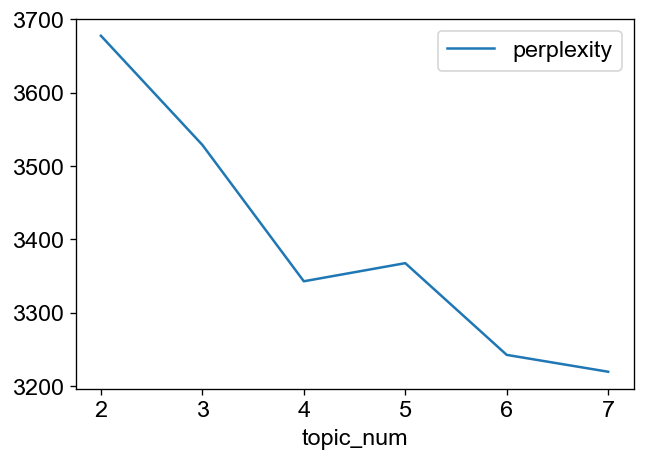

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

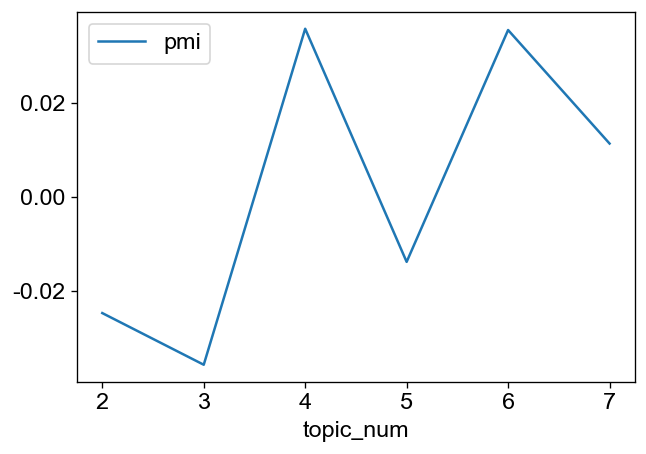

In [ ]:
result.plot.line(x='topic_num', y='pmi')

從訓練結果來看，或發現perplexity在 7 最好，而pmi則是4，故以下best_model建立將選擇4作為num_topics
主要基於以下理由：
* PMI指標(主題一致性)對主題模型的解釋性更為關鍵，而主題數為4時PMI達到最高
* 雖然困惑度在主題數為7時最低，但從4到7的改善相對有限
* 主題數為4提供了困惑度和一致性之間的最佳平衡點
* 考慮到模型簡潔性和可解釋性，較少的主題數通常更實用

In [ ]:
#本小組依以上結果，選擇num_topics為4
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2025-04-20 14:02:35,108 : INFO : using symmetric alpha at 0.25
2025-04-20 14:02:35,110 : INFO : using symmetric eta at 0.25
2025-04-20 14:02:35,112 : INFO : using serial LDA version on this node
2025-04-20 14:02:35,115 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 2980 documents, updating model once every 2000 documents, evaluating perplexity every 2980 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 14:02:35,116 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-20 14:02:35,116 : INFO : PROGRESS: pass 0, at document #2000/2980
2025-04-20 14:02:35,640 : INFO : merging changes from 2000 documents into a model of 2980 documents
2025-04-20 14:02:35,642 : INFO : topic #0 (0.250): 0.007*"漲幅" + 0.005*"台股" + 0.005*"最高" + 0.005*"早盤" + 0.005*"族群" + 0.005*"代表" + 0.004*"立場" + 0.004*"股價" + 0.004*"言論" + 0.004*"掌握"
2025-04-20 14:02

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.113322 -0.144897       1        1  50.455847
2     -0.148977 -0.033263       2        1  18.845463
0     -0.207750  0.070709       3        1  16.068592
3      0.243404  0.107452       4        1  14.630098, topic_info=     Term         Freq        Total Category  logprob  loglift
4191  中華隊  2750.000000  2750.000000  Default  30.0000  30.0000
8571   漲幅  1064.000000  1064.000000  Default  29.0000  29.0000
5666   台股  1108.000000  1108.000000  Default  28.0000  28.0000
8754   投手  1249.000000  1249.000000  Default  27.0000  27.0000
22     台灣  3109.000000  3109.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
352    代表   479.659515  1356.505023   Topic4  -4.9037   0.8825
2644   市場   331.201728   736.236227   Topic4  -5.2741   1.1233
700    部分   272.873264   516.933726   Topic4  -5.4678   1.2832
907    掌握   293.191845  1193.088124   Topic4  -5.3960   0.5186
323    網友   233.575904  1018.464641   Topic4  -5.6233   0.4495

[328 rows x 6 columns], token_table=       Topic      Freq Term
term                       
10311      2  0.066410   一壘
10311      3  0.929737   一壘
10691      2  0.024030  一壘手
10691      3  0.937176  一壘手
2033       1  0.983093   丈夫
...      ...       ...  ...
8606       2  0.726874   體育
8606       3  0.261674   體育
8606       4  0.004846   體育
10129      2  0.948982  體育局
10486      2  0.969755   鬥士

[758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [ ]:
#將主題改成6看看差異
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-20 14:02:42,791 : INFO : using symmetric alpha at 0.16666666666666666
2025-04-20 14:02:42,793 : INFO : using symmetric eta at 0.16666666666666666
2025-04-20 14:02:42,796 : INFO : using serial LDA version on this node
2025-04-20 14:02:42,803 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 2980 documents, updating model once every 2000 documents, evaluating perplexity every 2980 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 14:02:42,803 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-20 14:02:42,807 : INFO : PROGRESS: pass 0, at document #2000/2980
2025-04-20 14:02:43,433 : INFO : merging changes from 2000 documents into a model of 2980 documents
2025-04-20 14:02:43,435 : INFO : topic #1 (0.167): 0.009*"美國" + 0.005*"報導" + 0.004*"川普" + 0.004*"公司" + 0.004*"網友" + 0.004*"台股" + 0.004*"掌握" + 0.003*"代表" + 0.003*"員工"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.115544  0.094180       1        1  39.185101
0      0.221731 -0.121943       2        1  16.208193
2      0.173220 -0.035277       3        1  15.907885
5     -0.047089  0.161813       4        1  12.312642
3     -0.264208 -0.185076       5        1  10.227119
4      0.031889  0.086303       6        1   6.159059, topic_info=     Term         Freq        Total Category  logprob  loglift
4191  中華隊  2721.000000  2721.000000  Default  30.0000  30.0000
8571   漲幅  1045.000000  1045.000000  Default  29.0000  29.0000
5666   台股  1086.000000  1086.000000  Default  28.0000  28.0000
8754   投手  1235.000000  1235.000000  Default  27.0000  27.0000
9102   早盤   646.000000   646.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
260    世界    71.551485  1418.579168   Topic6  -5.9412  -0.1997
9479   巨蛋    66.222044   761.425478   Topic6  -6.0186   0.3451
59     時間    65.286703   614.057298   Topic6  -6.0328   0.5459
809    使用    61.359286   320.074618   Topic6  -6.0949   1.1354
78     現場    61.155330   478.128188   Topic6  -6.0982   0.7308

[501 rows x 6 columns], token_table=       Topic      Freq Term
term                       
6804       4  0.907145   一命
10311      2  0.946178   一壘
10311      3  0.038229   一壘
884        1  0.153354   一處
884        4  0.834926   一處
...      ...       ...  ...
7007       6  0.915134   黑道
2476       6  0.893712   黑鷹
5757       5  0.971651   點或
7606       6  0.957083   點燈
9189       5  0.981844   點跌

[1442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 6, 4, 5])

In [ ]:
#pyLDAvis.save_html(p, "lda_zh.html")

從上面兩張圖可看出若以Topic 3為例來做比較：

設定4個主題的 Top-30 Most Relevant Terms for Topic 3 為 16.1%， 設定5個主題的 Top-30 Most Relevant Terms for Topic 3 為 15.9%，可知4個主題的Relevant Terms來得更好。


# 4.GuidedLDA

LDA作為當前主流的主題模型算法之一，可快速地概括大量對話的主要內容，
但是在某些主題關鍵詞的描述上並不是特別的準確，多個主題之間容易產生交叉以及容易出現話題無關的關鍵詞。

GuidedLDA 是可選半監督主題識別算法，所謂“可選”是指，可以提前設置主題的種子詞
再將後有選擇的把自定義的主題傳入模型中， 通過設置種子詞，引導算法朝預設的話題方向匯集，達到話題半監督的目的。




In [ ]:
import guidedlda
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一度', '一直', '中有', '事先', '事實上', '事情', '代言', '保護', '價值', '億美元')

In [ ]:
word2id = dictionary.token2id

In [ ]:
# 自行設定種子詞列表
seed_topic_list = [
    # 主題1：體育新聞（棒球相關）
    ["投手", "中華隊", "棒球", "道奇", "球員", "先發", "球迷", "敲出", "世界", "經典"],  
    # 主題2：國際政治新聞
    ["美國", "中國", "總統", "政府", "川普", "戰爭", "國際", "俄羅斯", "關係", "外交"],
    # 主題3：財經新聞
    ["台股", "漲幅", "股價", "市場", "台積", "台積電", "投資", "基金", "金融", "經濟"],
    # 主題4：台灣民生新聞
    ["台灣", "民眾", "生活", "事件", "社會", "調查", "問題", "活動", "服務", "教育"]
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-20 14:02:49,415 : INFO : n_documents: 2980
2025-04-20 14:02:49,420 : INFO : vocab_size: 11173
2025-04-20 14:02:49,425 : INFO : n_words: 441920
2025-04-20 14:02:49,426 : INFO : n_topics: 4
2025-04-20 14:02:49,426 : INFO : n_iter: 100
2025-04-20 14:02:51,433 : INFO : <0> log likelihood: -4489695
2025-04-20 14:02:51,754 : INFO : <20> log likelihood: -3653288
2025-04-20 14:02:52,063 : INFO : <40> log likelihood: -3636896
2025-04-20 14:02:52,369 : INFO : <60> log likelihood: -3630495
2025-04-20 14:02:52,677 : INFO : <80> log likelihood: -3629113
2025-04-20 14:02:52,984 : INFO : <99> log likelihood: -3627836


In [ ]:
# 整理／顯示主題模型結果
#n_top_words = 10
n_top_words = 5
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 中華隊 台灣 棒球 投手 世界
Topic 1: 美國 台灣 中國 川普 總統
Topic 2: 台股 漲幅 股價 早盤 最高
Topic 3: 報導 發生 發現 網友 民眾


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.192691 -0.161828       1        1  29.684461
3     -0.076880  0.288390       2        1  29.594603
1     -0.057913 -0.084163       3        1  22.755896
2      0.327484 -0.042400       4        1  17.965041, topic_info=     Term         Freq        Total Category  logprob  loglift
4191  中華隊  2756.000000  2756.000000  Default  30.0000  30.0000
102    美國  2334.000000  2334.000000  Default  29.0000  29.0000
5666   台股  1156.000000  1156.000000  Default  28.0000  28.0000
8571   漲幅  1112.000000  1112.000000  Default  27.0000  27.0000
22     台灣  3217.000000  3217.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
404    立場   560.264624  1220.662702   Topic4  -4.9537   0.9380
2635  台積電   352.540979   502.411707   Topic4  -5.4170   1.3625
323    網友   402.474548  1031.935841   Topic4  -5.2845   0.7752
907    掌握   421.449304  1221.717515   Topic4  -5.2384   0.6524
700    部分   325.576853   533.409042   Topic4  -5.4965   1.2231

[255 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2033       2  1.000601   丈夫
10425      1  1.000721   三振
803        3  1.000674   上任
256        4  1.001131   上市
257        2  0.016213   上漲
...      ...       ...  ...
1979       2  1.000702   飛機
2332       2  1.000568   餐廳
137        3  1.000705  馬斯克
8516       4  1.001095   鴻海
1705       3  1.000759  黎巴嫩

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

# 5.主題分佈的應用，搭配其他文章資訊

訓練完LDA模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [ ]:
# 取得每條PO文的主題分佈，以best_model型來找出主題
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
#顯示了第101篇文章(索引100)的主題分布情況：
topics_doc[100]

[(1, 0.9967163)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.        , 0.84372169, 0.15337189, 0.        ],
       [0.        , 0.99500269, 0.        , 0.        ],
       [0.        , 0.99470991, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.99569911, 0.        ],
       [0.        , 0.        , 0.99432421, 0.        ],
       [0.        , 0.06727636, 0.92891377, 0.        ]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
ebc['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [ ]:
ebc['topic_label'].value_counts()

topic_label
2    1503
3     526
4     488
1     463
Name: count, dtype: int64

In [ ]:
ebc.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,史上最強銀彈後援馬斯克助川普重返白宮之路美國總統大選開票從台灣時間日早上開始進行在點分時川普...,https://news.ebc.net.tw/news/world/452395,國際,2024-11-06 16:43:00,"[史上, 最強, 銀彈, 後援, 馬斯克, 助川普, 重返, 白宮, 美國, 總統大選, 開...",2
1,日富豪興奮劑中毒亡女優嫩妻驚吐實情為錢才嫁日本富豪野崎幸助於年因急性興奮劑中毒不幸身亡前妻須...,https://news.ebc.net.tw/news/world/454522,國際,2024-11-17 17:44:00,"[富豪, 興奮劑, 中毒, 女優, 妻驚, 實情, 日本, 富豪, 野崎幸, 助於, 急性,...",2
2,不滿遊戲政治正確馬斯克放話欲買下玩具商孩之寶世界上第一款角色扮演桌遊龍與地下城日前陷入政治正...,https://news.ebc.net.tw/news/world/457026,國際,2024-11-30 20:25:00,"[遊戲, 政治, 正確, 馬斯克, 放話, 買下, 玩具商, 孩之寶, 世界, 第一款, 角...",2
3,質疑店員做披薩沒戴手套歲男竟狠心槍殺對方美國威斯康辛州一名歲男子查爾斯萊格特因為在訂購披薩時...,https://news.ebc.net.tw/news/world/450628,國際,2024-10-28 16:42:00,"[質疑, 店員, 披薩, 沒戴, 手套, 男竟, 狠心, 槍殺, 對方, 美國, 威斯康辛,...",2
4,煮飯只顧滑滑滑陸女手機滑進油鍋報銷中國大陸一名女子在油鍋前做菜時只顧著滑手機結果手一滑手機不...,https://news.ebc.net.tw/news/world/453547,國際,2024-11-12 16:51:00,"[煮飯, 只顧, 滑滑, 滑陸, 手機, 滑進, 油鍋, 報銷, 中國, 大陸, 女子, 油...",2


In [ ]:
#將artDate進行時間格式轉換
ebc['artDate'] = pd.to_datetime(ebc['artDate'])
ebc['artDate']

0      2024-11-06 16:43:00
1      2024-11-17 17:44:00
2      2024-11-30 20:25:00
3      2024-10-28 16:42:00
4      2024-11-12 16:51:00
               ...        
2975   2024-11-25 20:40:00
2976   2024-11-11 14:42:00
2977   2025-01-25 18:24:00
2978   2024-12-16 15:39:00
2979   2024-12-12 14:07:00
Name: artDate, Length: 2980, dtype: datetime64[ns]

In [ ]:
ebc['artDate'].dt.date

0       2024-11-06
1       2024-11-17
2       2024-11-30
3       2024-10-28
4       2024-11-12
           ...    
2975    2024-11-25
2976    2024-11-11
2977    2025-01-25
2978    2024-12-16
2979    2024-12-12
Name: artDate, Length: 2980, dtype: object

#### 查看每天每個主題的文章相對比例（占比）

In [ ]:
#透過groupby合併日期，列出資料集中2024-09-01 到 2025-02-28 每日不同主題的比率
ebc.groupby(ebc['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-09-01  2              0.666667
            1              0.333333
2024-09-02  2              0.636364
            3              0.181818
            4              0.181818
                             ...   
2025-02-27  4              0.200000
2025-02-28  2              0.500000
            3              0.277778
            1              0.111111
            4              0.111111
Name: proportion, Length: 557, dtype: float64

In [ ]:
date_topic = ebc.groupby(ebc['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()

#將這些NaN值視為0（表示該日期沒有該主題的文章）
date_topic = date_topic.fillna(0)

date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2024-09-01,0.333333,0.666667,0.000000,0.000000
2024-09-02,0.000000,0.636364,0.181818,0.181818
2024-09-03,0.055556,0.611111,0.166667,0.166667
2024-09-04,0.062500,0.437500,0.062500,0.437500
2024-09-05,0.000000,0.363636,0.272727,0.363636


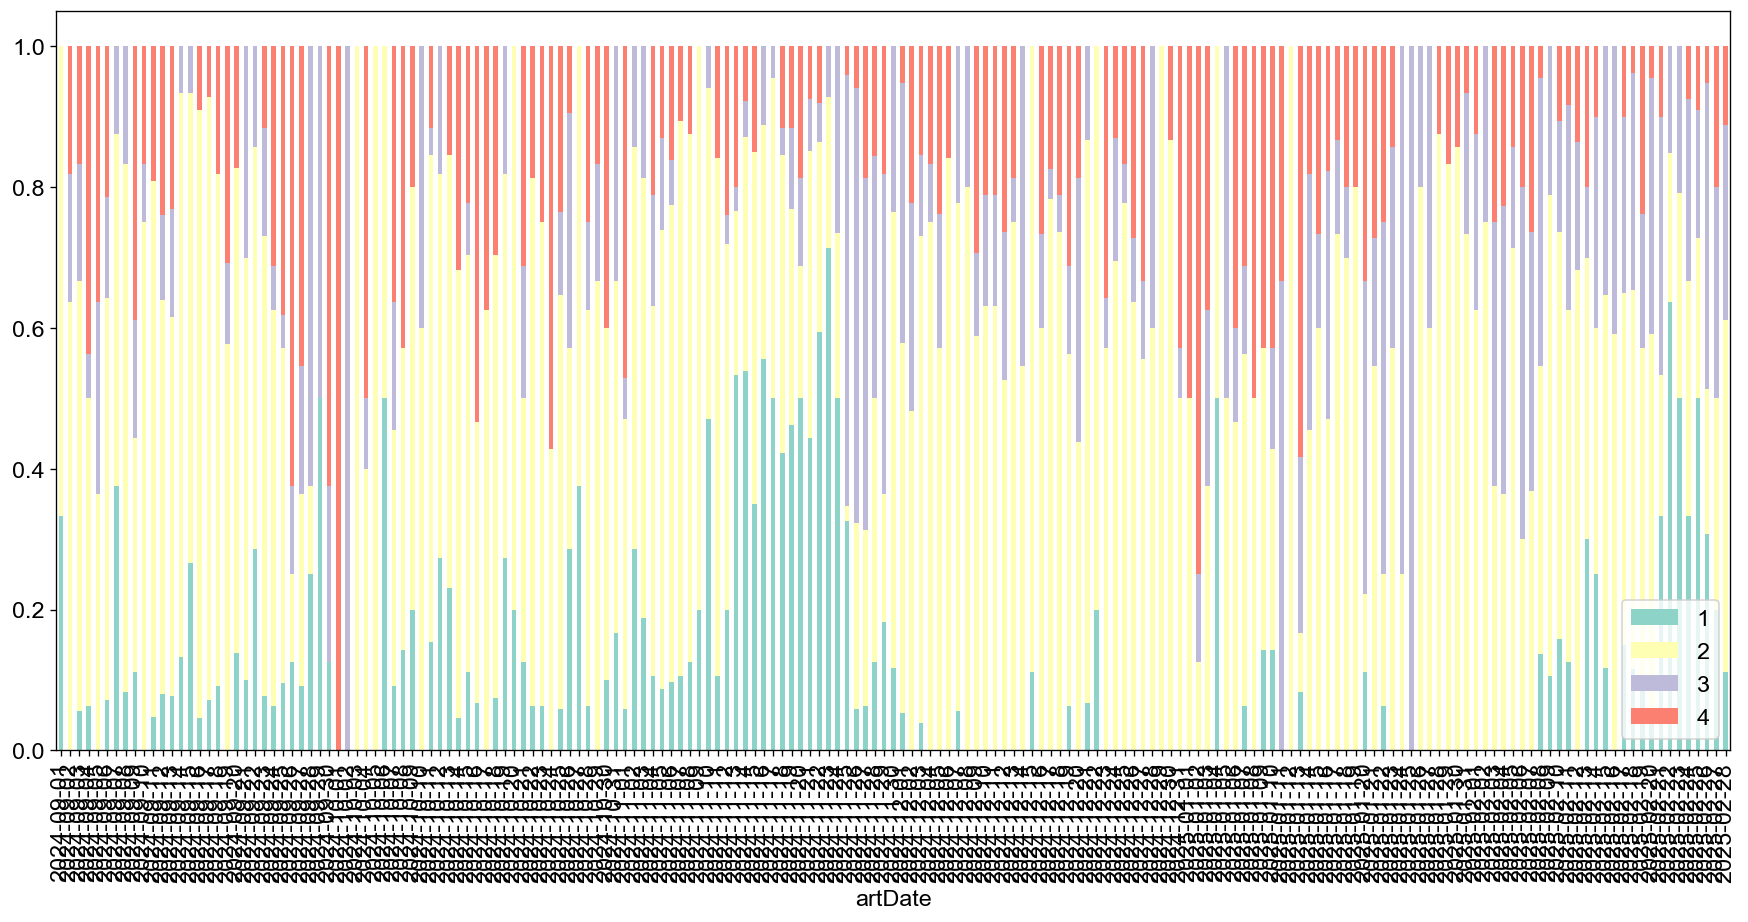

In [ ]:
#搭配文章中的日期資訊資訊來結合主題分佈結果進行繪圖
fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # 减少日期标签数量
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

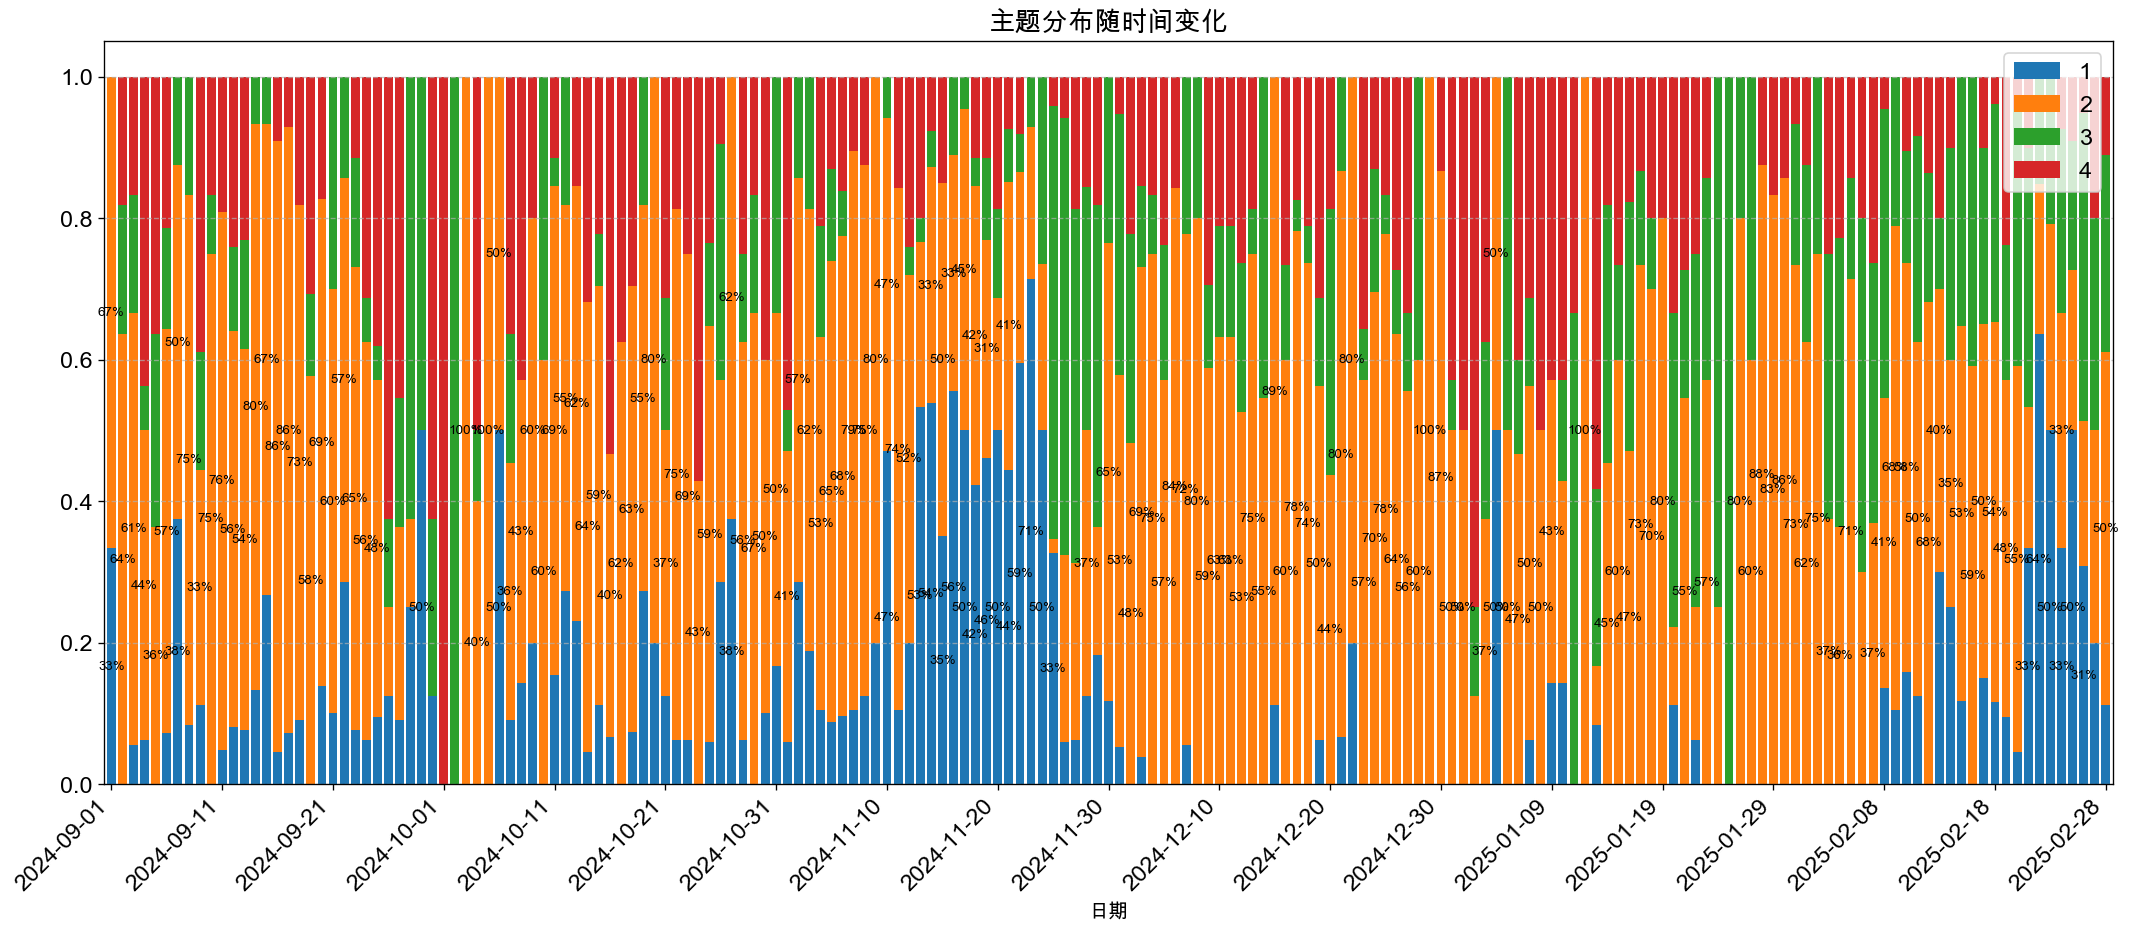

In [ ]:
# 优化日期显示
fig, ax = plt.subplots(figsize=(18, 8))

# 绘制堆叠柱状图
date_topic.plot.bar(ax=ax, stacked=True, 
                   color=plt.cm.tab10.colors,  # 使用更鲜明的配色方案
                   width=0.8)  # 调整柱子宽度

# 设置轴标签和标题
ax.set_title('主题分布随时间变化', fontsize=16)
ax.set_xlabel('日期', fontsize=12)

# 优化x轴日期显示
plt.xticks(rotation=45, ha='right')  # 旋转日期标签
ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # 减少日期标签数量

# 添加网格线以便于阅读
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 添加图例，并为主题添加更有意义的名称
ax.legend( loc='upper right', bbox_to_anchor=(1, 1))

# 添加数据标签以显示重要趋势
for i, topic in enumerate([2, 6]):  # 为主要主题添加百分比标签
    for j, p in enumerate(ax.patches[i*len(date_topic):(i+1)*len(date_topic)]):
        if p.get_height() > 0.3:  # 只标注比例较大的部分
            ax.annotate(f'{p.get_height():.0%}', 
                       (p.get_x() + p.get_width()/2., p.get_y() + p.get_height()/2.),
                       ha='center', va='center', fontsize=8, color='black',
                       xytext=(0, 0), textcoords='offset points')


plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
zscore = stats.zscore(date_topic)
anomalies = (abs(zscore) > 3).any(axis=1)
date_topic[anomalies]  # 显示异常日期

topic_label,1,2,3,4
artDate,,,,
2024-10-01,0.000000,0.000000,0.000000,1.00
2024-10-02,0.000000,0.000000,1.000000,0.00
2024-11-23,0.714286,0.214286,0.071429,0.00
2025-01-02,0.000000,0.125000,0.125000,0.75
2025-01-24,0.000000,0.250000,0.750000,0.00
2025-01-25,0.000000,0.000000,1.000000,0.00
2025-02-22,0.636364,0.212121,0.151515,0.00


#### 按週整合數據後再繪製長條圖


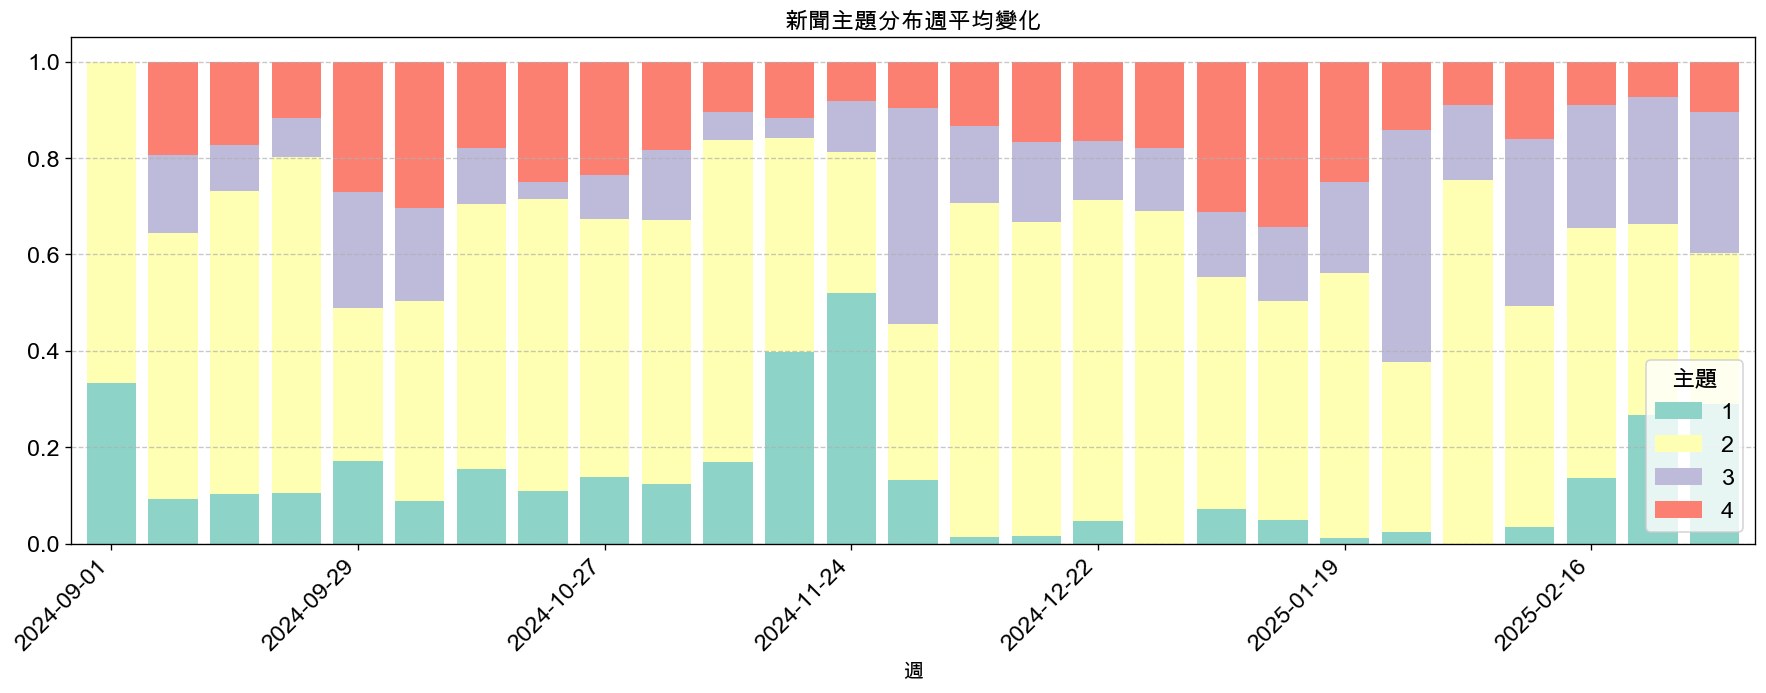

In [ ]:
# 日期索引轉換為datetime
date_topic_filled = date_topic.fillna(0)
date_topic_filled.index = pd.to_datetime(date_topic_filled.index)

# 按週整合數據
weekly_topic = date_topic_filled.resample('W').mean()

# 繪製堆疊長條圖
fig, ax = plt.subplots(figsize=(15, 6))
weekly_topic.plot.bar(ax=ax, stacked=True, width=0.8, color=plt.cm.Set3.colors)

# 添加網格線
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 添加標題和labels
ax.set_title('新聞主題分布週平均變化', fontsize=14)
ax.set_xlabel('週', fontsize=12)

# 優化x軸
# 只顯示每月第一週
every_4th_label = np.arange(0, len(weekly_topic), 4)
ax.set_xticks(every_4th_label)
ax.set_xticklabels([weekly_topic.index[i].strftime('%Y-%m-%d') for i in every_4th_label], 
                   rotation=45, ha='right')

# 調整圖例
ax.legend(loc='lower right', title='主題')

# 添加图例，并为主题添加更有意义的名称
# ax.legend(['国际政治新闻', '台湾棒球', '金融股市', '棒球赛事', '韩国政治', '社交媒体事件'], 
#           loc='upper right', bbox_to_anchor=(1, 1))

# 確保標籤不會被裁剪
plt.tight_layout()


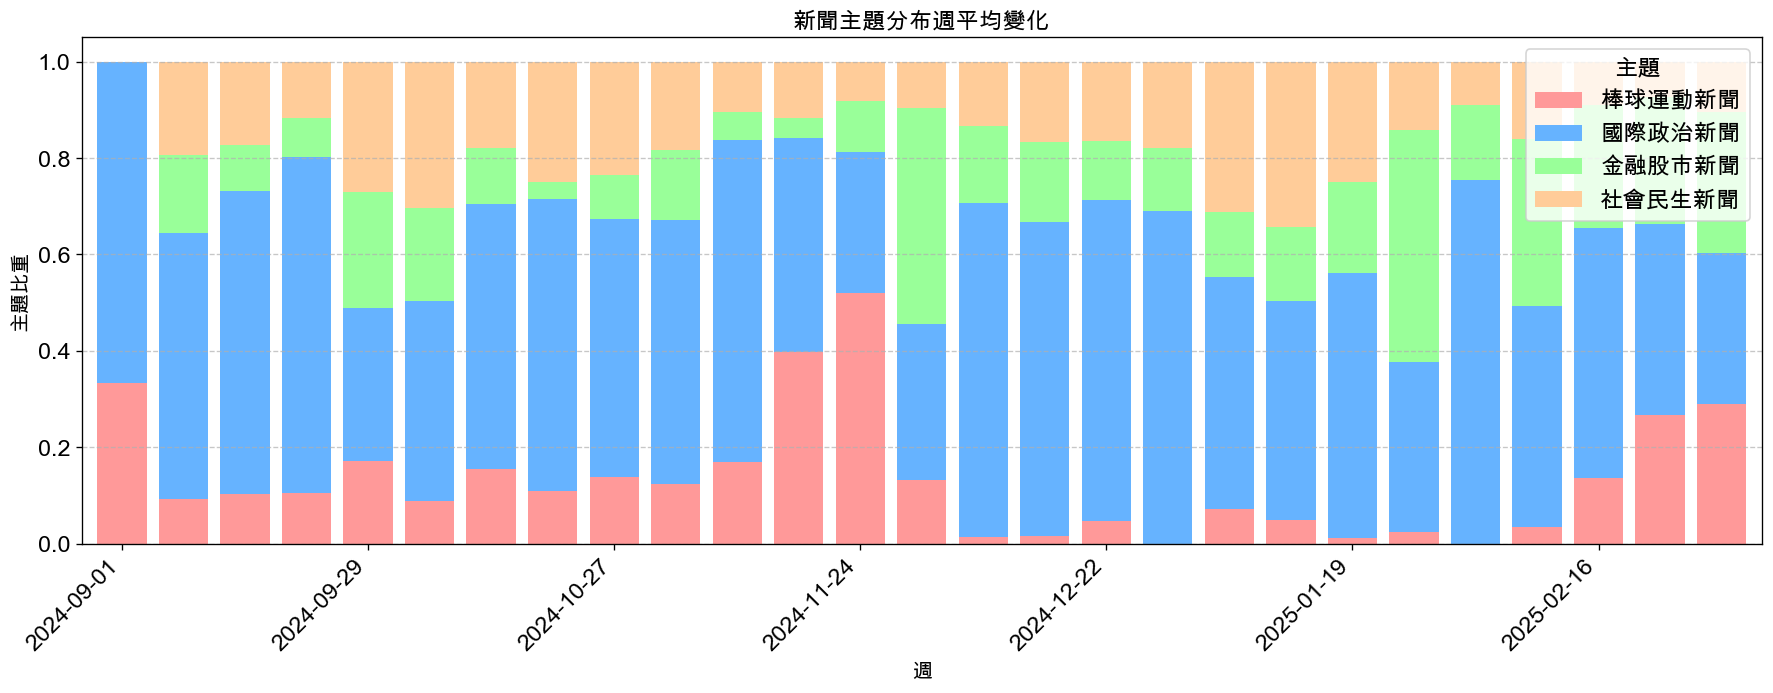

In [ ]:
# 日期索引轉換為datetime
date_topic_filled = date_topic.fillna(0)
date_topic_filled.index = pd.to_datetime(date_topic_filled.index)

# 按週整合數據
weekly_topic = date_topic_filled.resample('W').mean()

# 繪製堆疊長條圖
fig, ax = plt.subplots(figsize=(15, 6))

# 使用更合適的顏色方案，僅選4種顏色
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # 自定義4個顏色
weekly_topic.plot.bar(ax=ax, stacked=True, width=0.8, color=colors)

# 添加網格線
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 添加標題和labels
ax.set_title('新聞主題分布週平均變化', fontsize=14)
ax.set_xlabel('週', fontsize=12)
ax.set_ylabel('主題比重', fontsize=12)

# 優化x軸
# 只顯示每月第一週
every_4th_label = np.arange(0, len(weekly_topic), 4)
ax.set_xticks(every_4th_label)
ax.set_xticklabels([weekly_topic.index[i].strftime('%Y-%m-%d') for i in every_4th_label], 
                   rotation=45, ha='right')

# 添加圖例，為主題添加更有意義的名稱
ax.legend(['棒球運動新聞', '國際政治新聞', '金融股市新聞', '社會民生新聞'], 
          loc='upper right', bbox_to_anchor=(1, 1), title='主題')

# 確保標籤不會被裁剪
plt.tight_layout()

# 顯示圖表
plt.show()

此圖結果為透過主題模型與時間序列的結合運用案例，

1.主題1（綠色）在特定時間點有明顯的比例增加，特別是11月中旬的顯著上升，很大可能是因為中華隊參與世界棒球錦標賽時，吸引媒體關注度大幅提升。證明了GuidedLDA模型成功捕捉了新聞主題的時間動態性。